The purpose of this notebook is to make outcome predictions.

Future usage of the numerically encoded dataset may need to consider dropping a reference category so this reference case is encoded when all values are zero.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
# # the "1" means: always reload modules marked with "%aimport"
%autoreload 2

from __future__ import absolute_import, division, print_function
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
# from tqdm import tqdm
# import warnings

# sns.set_context("poster", font_scale=0.9)
sns.set_context("notebook", font_scale=1.0)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# add the data functions to the path
src_data_dir = os.path.join(os.getcwd(), os.pardir, 'src/data')
sys.path.append(src_data_dir)

# functions to load the data
import homeless_dataset as hd

In [2]:
# my gist from https://gist.github.com/warmlogic/afaf1d2b1ce90927d14f008571b6f6f0
import classify_utils as cu

In [3]:
datadir_raw = os.path.join(os.getenv('HOME'), 'Dropbox', 'C4SF-datasci-homeless', 'raw')
datadir_proc = os.path.join(os.getenv('HOME'), 'Dropbox', 'C4SF-datasci-homeless', 'processed')

In [4]:
# load the data

df_features = pd.read_csv(os.path.join(datadir_proc, '2017-01-22_homeless_summary_categorical_string.csv'), header=0, index_col=0)

In [5]:
df_features.describe()

chronic_homeless  client_age_at_entry  continuously_homeless_one_year  \
count      11362.000000         11362.000000                    11362.000000   
mean           0.059849            33.622250                        0.185443   
std            0.237217            20.246602                        0.388673   
min            0.000000             0.000000                        0.000000   
25%            0.000000            16.000000                        0.000000   
50%            0.000000            34.000000                        0.000000   
75%            0.000000            51.000000                        0.000000   
max            1.000000           101.000000                        1.000000   

       days_enrolled  days_to_residential_move_in  disabling_condition  \
count   11362.000000                   747.000000         11362.000000   
mean      207.853459                    72.552878             0.390512   
std       330.189494                    81.557515             0.487887   
min         0.000000                     1.000000             0.000000   
25%        26.000000                    16.000000             0.000000   
50%        96.000000                    48.000000             0.000000   
75%       258.000000                    97.000000             1.000000   
max      5040.000000                   730.000000             1.000000   

       domestic_violence_victim  dv_currently_fleeing   enrollments  \
count              11362.000000          11362.000000  11362.000000   
mean                   0.183154              0.001672      5.123130   
std                    0.386810              0.040861     18.586563   
min                    0.000000              0.000000      1.000000   
25%                    0.000000              0.000000      1.000000   
50%                    0.000000              0.000000      2.000000   
75%                    0.000000              0.000000      2.000000   
max                    1.000000              1.000000    577.000000   

       head_of_household  in_permanent_housing  months_ago_dv_occurred  \
count       11362.000000          11362.000000             1910.000000   
mean            0.409347              0.101039               16.102618   
std             0.491735              0.301393                9.192029   
min             0.000000              0.000000                3.000000   
25%             0.000000              0.000000                6.000000   
50%             0.000000              0.000000               24.000000   
75%             1.000000              0.000000               24.000000   
max             1.000000              1.000000               24.000000   

       months_homeless_this_time  times_homeless_past_three_years  \
count                1726.000000                      5202.000000   
mean                    6.976246                         1.346790   
std                     9.969520                         1.122937   
min                     0.000000                         0.000000   
25%                     0.000000                         1.000000   
50%                     1.000000                         1.000000   
75%                    12.000000                         2.000000   
max                    24.000000                         4.000000   

       times_in_permanent_housing   transsexual  veteran_status  \
count                11362.000000  11362.000000    11362.000000   
mean                     0.139236      0.002640        0.192836   
std                      1.042184      0.051319        0.394543   
min                      0.000000      0.000000        0.000000   
25%                      0.000000      0.000000        0.000000   
50%                      0.000000      0.000000        0.000000   
75%                      0.000000      0.000000        0.000000   
max                     68.000000      1.000000        1.000000   

       noncash_benefit_tanfother  noncash_benefit_wic  \
count               11362.000

# Run an overall logistic regression model for everyone together

In [6]:
# drop features that are related to the outcome

outcome = 'in_permanent_housing'
outcome_related = ['days_to_residential_move_in', 'times_in_permanent_housing', 'head_of_household']

df_model = df_features.copy()

for col in outcome_related:
    if col in df_model.columns:
        df_model = df_model.drop(col, axis=1)

In [7]:
# fill in any missing values with the median for that column
for col, typ in df_model.dtypes.iteritems():
    if typ != 'object':
        df_model[[col]] = df_model[[col]].apply(lambda x: x.fillna(x.median()))

In [8]:
# drop some rows that make up few enough of certain categories that they cause issues with logistic regression

living_vals_drop = [
    'owned',
    'safehaven',
    'foster',
    'permanenthousing',
    'halfwayhouse',
    'ownedsubsidy',
    'longtermcare',
    'rentalgdptip',
]

df_model = df_model.loc[(df_model['gender'] != 'unknown') &
                        (df_model['housing_status_project_start'] != 'cat3homelessfedstatutes') &
                        (df_model['housing_status_project_start'] != 'cat4fleeingdv') &
                        (df_model['housing_status_project_start'] != 'housed') &
                        df_model['living_situation_before_program_entry'].apply(lambda x: False if x in living_vals_drop else True), :]

In [9]:
outcome = 'in_permanent_housing'

f = """
in_permanent_housing ~ client_age_at_entry 
+ chronic_homeless 
+ domestic_violence_victim 
+ disabling_condition 
+ veteran_status 
+ C(gender) 
+ C(race) 
+ C(ethnicity) 
+ C(project_type_code) 
+ C(housing_status_project_start) 
+ C(living_situation_before_program_entry) 
+ continuously_homeless_one_year 
+ I(days_enrolled / (365.25 / 12))
+ dv_currently_fleeing 
+ enrollments 
+ months_ago_dv_occurred 
+ months_homeless_this_time 
+ times_homeless_past_three_years 
+ transsexual 
+ noncash_benefit_tanfother 
+ noncash_benefit_wic 
+ noncash_benefit_publichousing 
+ noncash_benefit_temprental 
+ noncash_benefit_other 
+ noncash_benefit_tanftransportation 
+ noncash_benefit_tanfchildcare 
+ noncash_benefit_foodstamps 
+ health_insurance_medicaid 
+ health_insurance_statechild 
+ health_insurance_stateadult 
+ health_insurance_veteranadmin 
+ health_insurance_pirvate 
+ health_insurance_employer 
+ health_insurance_medicare 
+ health_insurance_cobra 
+ disability_type_alcohol 
+ disability_type_alcoholdrug 
+ disability_type_chronichealth 
+ disability_type_developmental 
+ disability_type_drug 
+ disability_type_dualdiagnosis 
+ disability_type_hearing 
+ disability_type_hivaids 
+ disability_type_mentalhealth 
+ disability_type_physical 
"""

# + head_of_household 

# these features are causing issues
# + disability_type_substance + disability_type_vision + disability_type_other 

results_log = cu.sm_logit(
    df_model,
    f=f,
    #maxiter=100,
    reg_method = 'l1',
    reg_alpha=0.1,
    )


in_permanent_housing ~ client_age_at_entry 
+ chronic_homeless 
+ domestic_violence_victim 
+ disabling_condition 
+ veteran_status 
+ C(gender) 
+ C(race) 
+ C(ethnicity) 
+ C(project_type_code) 
+ C(housing_status_project_start) 
+ C(living_situation_before_program_entry) 
+ continuously_homeless_one_year 
+ I(days_enrolled / (365.25 / 12))
+ dv_currently_fleeing 
+ enrollments 
+ months_ago_dv_occurred 
+ months_homeless_this_time 
+ times_homeless_past_three_years 
+ transsexual 
+ noncash_benefit_tanfother 
+ noncash_benefit_wic 
+ noncash_benefit_publichousing 
+ noncash_benefit_temprental 
+ noncash_benefit_other 
+ noncash_benefit_tanftransportation 
+ noncash_benefit_tanfchildcare 
+ noncash_benefit_foodstamps 
+ health_insurance_medicaid 
+ health_insurance_statechild 
+ health_insurance_stateadult 
+ health_insurance_veteranadmin 
+ health_insurance_pirvate 
+ health_insurance_employer 
+ health_insurance_medicare 
+ health_insurance_cobra 
+ disability_type_alcohol 
+ disa

In [10]:
cu.print_sm_logit_results(results_log);

0                     1                  2          3
0               Model:                 Logit  Pseudo R-squared:      0.460
1  Dependent Variable:  in_permanent_housing               AIC:  3766.7197
2                Date:      2017-01-29 22:48               BIC:  4288.0204
3    No. Observations:                 10304    Log-Likelihood:    -1811.4
4            Df Model:                    71           LL-Null:    -3355.4
5        Df Residuals:                 10232       LLR p-value:     0.0000
6           Converged:                  True             Scale:     1.0000
7      No. Iterations:              961.0000

As feature increases, more likely to be in positive class:


Coef.  Odds Ratio  \
C(project_type_code)[T.rapidrehousing]              4.908367  135.418154   
C(project_type_code)[T.homelessnessprevention]      3.659648   38.847652   
C(project_type_code)[T.servicesonly]                2.784794   16.196489   
I(days_enrolled / (365.25 / 12))                    0.049419    1.050660   
health_insurance_statechild                         1.936328    6.933249   
health_insurance_stateadult                         2.087167    8.062039   
health_insurance_medicaid                           0.955036    2.598764   
noncash_benefit_publichousing                       1.565857    4.786776   
health_insurance_veteranadmin                       0.899212    2.457665   
C(housing_status_project_start)[T.cat1homeless]     1.191222    3.291101   
C(project_type_code)[T.permanentsupportivehousing]  2.533498   12.597493   
C(housing_status_project_start)[T.unknown]          1.092106    2.980544   
veteran_status                                      0.719759    2.053939   
continuously_homeless_one_year                      0.578869    1.784020   
C(living_situation_before_program_entry)[T.rental]  2.227616    9.277725   
C(race)[T.asian]                                    1.103760    3.015483   
C(living_situation_before_program_entry)[T.rent...  2.111256    8.258609   
C(living_situation_before_program_entry)[T.rent...  2.024745    7.574179   
C(race)[T.white]                                    0.694812    2.003333   
C(race)[T.black]                                    0.752835    2.123010   
months_homeless_this_time                           0.027687    1.028074   
C(living_situation_before_program_entry)[T.hotel]   1.666685    5.294586   
disability_type_mentalhealth                        0.393490    1.482145   
health_insurance_employer                           1.087220    2.966017   
disability_type_physical                            0.322986    1.381246   

                                                    Std.Err.          z  \
C(project_type_code)[T.rapidrehousing]              0.265491  18.487871   
C(project_type_code)[T.homelessnessprevention]      0.264520  13.835042   
C(project_type_code)[T.servicesonly]                0.250340  11.124036   
I(days_enrolled / (365.25 / 12))                    0.005002   9.880026   
health_insurance_statechild                         0.212476   9.113154   
health_insurance_stateadult                         0.233664   8.932325   
health_insurance_medicaid                           0.120070   7.954012   
noncash_benefit_publichousing                       0.276864   5.655686   
health_insurance_veteranadmin                       0.159587   5.634628   
C(housing_status_project_start)[T.cat1homeless]     0.245653   4.849209   
C(project_type_code)[T.permanentsupportivehousing]  0.562487   4.504099   
C(housing_status_project_start)[T.unknown]          0.244164   4.472830   
veteran_status                                      0.184218   3.907113   
continuously_homeless_one_year                      0.148484   3.898520   
C(living_situation_before_program_entry)[T.rental]  0.622642   3.577687   
C(race)[T.asian]                                    0.338500   3.260736   
C(living_situation_before_program_entry)[T.rent...  0.662861   3.185066   
C(living_situation_before_program_entry)[T.rent...  0.648383   3.122760   
C(race)[T.white]                                    0.230339   3.016474   
C(race)[T.black]                                    0.257026   2.929028   
months_homeless_this_time                           0.009857   2.808943   
C(living_situation_before_program_entry)[T.hotel]   0.626546   2.660117   
disability_type_mentalhealth                        0.164802   2.387657   
health_insurance_employer                           0.462928   2.348573   
disability_type_physical                            0.162250   1.990668   

                                                           P>|z|    [0.025  \
C(project_type_code)[T.rapidrehousing]           


As feature increases, less likely to be in positive class:


Coef.   Odds Ratio  Std.Err.  \
Intercept                                   -8.702516  6018.032911  0.846053   
times_homeless_past_three_years             -0.320865     1.378320  0.068099   
disabling_condition                         -0.534679     1.706900  0.124901   
health_insurance_cobra                      -4.500943    90.102070  1.089685   
noncash_benefit_wic                         -1.716936     5.567443  0.451397   
domestic_violence_victim                    -0.745527     2.107552  0.201895   
disability_type_hivaids                     -2.195468     8.984206  0.787771   
C(ethnicity)[T.nonlatino]                   -0.285546     1.330488  0.110063   
disability_type_drug                        -0.911825     2.488859  0.369574   
C(project_type_code)[T.transitionalhousing] -1.129492     3.094084  0.517094   
C(gender)[T.male]                           -0.226748     1.254514  0.105891   
disability_type_developmental               -0.865700     2.376668  0.423787   

                                                     z         P>|z|  \
Intercept                                   -10.286015  8.147937e-25   
times_homeless_past_three_years              -4.711750  2.455989e-06   
disabling_condition                          -4.280826  1.862007e-05   
health_insurance_cobra                       -4.130499  3.619773e-05   
noncash_benefit_wic                          -3.803602  1.426075e-04   
domestic_violence_victim                     -3.692645  2.219336e-04   
disability_type_hivaids                      -2.786937  5.320887e-03   
C(ethnicity)[T.nonlatino]                    -2.594397  9.475710e-03   
disability_type_drug                         -2.467233  1.361619e-02   
C(project_type_code)[T.transitionalhousing]  -2.184305  2.893981e-02   
C(gender)[T.male]                            -2.141331  3.224739e-02   
disability_type_developmental                -2.042773  4.107490e-02   

                                                [0.025    0.975]  
Intercept                                   -10.360750 -7.044282  
times_homeless_past_three_years              -0.454337 -0.187394  
disabling_condition                          -0.779480 -0.289878  
health_insurance_cobra                       -6.636687 -2.365199  
noncash_benefit_wic                          -2.601658 -0.832213  
domestic_violence_victim                     -1.141235 -0.349820  
disability_type_hivaids                      -3.739471 -0.651465  
C(ethnicity)[T.nonlatino]                    -0.501265 -0.069827  
disability_type_drug                         -1.636176 -0.187473  
C(project_type_code)[T.transitionalhousing]  -2.142978 -0.116006  
C(gender)[T.male]                            -0.434291 -0.019205  
disability_type_developmental                -1.696306 -0.035093

# Run separate models for different groups

Use sklearn, with one-hot encoded categorical data

## Groups to predict permanent housing outcome

- veteran_status
- chronic_homeless
- continuously_homeless_one_year
- disabling_condition
- domestic_violence_victim
- gender_female
- gender_male
- ethnicity_latino
- ethnicity_nonlatino


In [11]:
df_features_num = pd.read_csv(os.path.join(datadir_proc, '2017-01-22_homeless_summary_categorical_numeric.csv'), header=0, index_col=0)

In [12]:
df_features_num.shape[0]

11362

In [13]:
df_features_num['in_permanent_housing'].sum()

1148

In [14]:
df_features_num['in_permanent_housing'].mean()

0.10103854955113536

In [15]:
df_features_num['times_in_permanent_housing'].value_counts()

0     10189
1       984
2       156
3        24
7         2
4         2
6         1
13        1
68        1
41        1
64        1
Name: times_in_permanent_housing, dtype: int64

In [16]:
# fewer than half a percent (0.5%) of people have these features
member_size_threshold=0.005

if member_size_threshold < 1:
    member_size_threshold = int(np.ceil(df_features_num.shape[0] * member_size_threshold))

cols_to_drop_few = df_features_num.columns[df_features_num.sum() < member_size_threshold].tolist()
print('Dropping these columns due to fewer than {} people having this:\n'.format(member_size_threshold), cols_to_drop_few)
df_features_num = df_features_num.drop(cols_to_drop_few, axis=1)

Dropping these columns due to fewer than 57 people having this:
 ['dv_currently_fleeing', 'gender_unknown', 'housing_status_project_start_cat4fleeingdv', 'living_situation_before_program_entry_halfwayhouse', 'living_situation_before_program_entry_longtermcare', 'living_situation_before_program_entry_ownedsubsidy', 'living_situation_before_program_entry_rentalgdptip', 'transsexual', 'noncash_benefit_temprental', 'health_insurance_cobra', 'disability_type_other', 'disability_type_dualdiagnosis', 'disability_type_substance', 'disability_type_hearing', 'disability_type_vision']


In [17]:
df_features_num.describe()

chronic_homeless  client_age_at_entry  continuously_homeless_one_year  \
count      11362.000000         11362.000000                    11362.000000   
mean           0.059849            33.622250                        0.185443   
std            0.237217            20.246602                        0.388673   
min            0.000000             0.000000                        0.000000   
25%            0.000000            16.000000                        0.000000   
50%            0.000000            34.000000                        0.000000   
75%            0.000000            51.000000                        0.000000   
max            1.000000           101.000000                        1.000000   

       days_enrolled  days_to_residential_move_in  disabling_condition  \
count   11362.000000                   747.000000         11362.000000   
mean      207.853459                    72.552878             0.390512   
std       330.189494                    81.557515             0.487887   
min         0.000000                     1.000000             0.000000   
25%        26.000000                    16.000000             0.000000   
50%        96.000000                    48.000000             0.000000   
75%       258.000000                    97.000000             1.000000   
max      5040.000000                   730.000000             1.000000   

       domestic_violence_victim   enrollments  ethnicity_latino  \
count              11362.000000  11362.000000      11362.000000   
mean                   0.183154      5.123130          0.458282   
std                    0.386810     18.586563          0.498278   
min                    0.000000      1.000000          0.000000   
25%                    0.000000      1.000000          0.000000   
50%                    0.000000      2.000000          0.000000   
75%                    0.000000      2.000000          1.000000   
max                    1.000000    577.000000          1.000000   

       ethnicity_nonlatino  ethnicity_unknown  gender_female   gender_male  \
count         11362.000000       11362.000000   11362.000000  11362.000000   
mean              0.521827           0.019891       0.426685      0.572346   
std               0.499545           0.139631       0.494618      0.494760   
min               0.000000           0.000000       0.000000      0.000000   
25%               0.000000           0.000000       0.000000      0.000000   
50%               1.000000           0.000000       0.000000      1.000000   
75%               1.000000           0.000000       1.000000      1.000000   
max               1.000000           1.000000       1.000000      1.000000   

       head_of_household  housing_status_project_start_atrisk  \
count       11362.000000                         11362.000000   
mean            0.409347                             0.091445   
std             0.491735                             1.094995   
min             0.000000                             0.000000   
25%             0.000000                             0.000000   
50%             0.000000                             0.000000   
75%             1.000000                             0.000000   
max             1.000000                            94.000000   

       housing_status_project_start_cat1homeless  \
count                               11362.000000   
mean                                    4.110720   
std                                    17.805798   
min                                     0.000000   
25%                                     0.000000   
50%                                     1.000000   
75%                                     2.000000   
max                                   577.000000   

       housing_status_project_start_cat2risklosing  \
count                                 11362.000000   
mean                                      0.273543   
std                                       1.394907   
min                                      

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# outcome = 'in_permanent_housing'
# outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing',
#                    #'project_type_code_rapidrehousing',
#                    #'days_enrolled',
#                   ]
# y = df_model_num[outcome].values
# X = df_model_num.drop(outcome_related, axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# print('train', X_train.shape)
# print('test', X_test.shape)

In [20]:
def predict_group(df_features_num, col, cols_to_drop,
                  val_to_keep=None,
                  test_size=0.33,
                  member_size_threshold=0.01,
                  print_n_features=20,
                  ):
    if val_to_keep is None:
        val_to_keep = 1
    
    print('\n{} = {}'.format(col, val_to_keep))
    
    #     # these columns have very few people
    #     cols_to_drop_few = [
    #         'gender_unknown',
    #         'housing_status_project_start_cat3homelessfedstatutes',
    #         'housing_status_project_start_cat4fleeingdv',
    #         'housing_status_project_start_housed',
    #         'living_situation_before_program_entry_owned',
    #         'living_situation_before_program_entry_safehaven',
    #         'living_situation_before_program_entry_foster',
    #         'living_situation_before_program_entry_permanenthousing',
    #         'living_situation_before_program_entry_halfwayhouse',
    #         'living_situation_before_program_entry_ownedsubsidy',
    #         'living_situation_before_program_entry_longtermcare',
    #         'living_situation_before_program_entry_rentalgdptip',
    #     ]

    df_model_num = df_features_num.copy()
    
    # df_model_num = df_model_num.drop(cols_to_drop_few, axis=1)
    
    # fill in any missing values with the median for that column
    df_model_num = df_model_num.apply(lambda x: x.fillna(x.median()),axis=0)

    # df_model_num.describe()
    
    df_model_num = df_model_num.loc[df_model_num[col] == val_to_keep, :]
    df_model_num = df_model_num.drop(cols_to_drop, axis=1)
    
    if member_size_threshold < 1:
        member_size_threshold = int(np.ceil(df_model_num.shape[0] * member_size_threshold))
    
    # drop columns where fewer than member_size_threshold have this
    cols_to_drop_few = df_model_num.columns[df_model_num.sum() < member_size_threshold].tolist()
    print('\nDropping these columns due to fewer than {} people having this:\n'.format(member_size_threshold), cols_to_drop_few)
    df_model_num = df_model_num.drop(cols_to_drop_few, axis=1)

    outcome = 'in_permanent_housing'
    outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing',
                       'head_of_household',
                       #'project_type_code_rapidrehousing',
                       #'days_enrolled',
                      ]
    y = df_model_num[outcome].values
    X = df_model_num.drop(outcome_related, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    print('')
    print('train', X_train.shape)
    print('test', X_test.shape)
    
    print('\n{} = {}'.format(col, val_to_keep))
    results, myAuc, precision, recall, f1, myLR = cu.classify(X_train, X_test,
                                                              y_train, y_test,
                                                              'lr',
                                                              print_n_features=print_n_features);
    return (results, myLR, y)

In [21]:
def collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep=None):
    if val_to_keep is not None:
        col = '{}_{}'.format(col, val_to_keep)
    results['odds'] = results['odds'] * results['coef'].apply(lambda x: np.sign(x))
    coef_df = odds_df.merge(results[['coef']].rename(columns={'coef': col}), how='left', left_index=True, right_index=True,)
    odds_df = odds_df.merge(results[['odds']].rename(columns={'odds': col}), how='left', left_index=True, right_index=True,)
    stat_df.loc[col, 'n'] = int(len(y))
    stat_df.loc[col, 'n_perm_housing'] = int(np.sum(y))
    stat_df.loc[col, 'prop_perm_housing'] = np.sum(y) / len(y)
    return (coef_df, odds_df, stat_df)

In [47]:
coef_df = pd.DataFrame(index=df_features_num.columns)
odds_df = pd.DataFrame(index=df_features_num.columns)
stat_df = pd.DataFrame()


gender_female = 1

Dropping these columns due to fewer than 49 people having this:
 ['living_situation_before_program_entry_foster', 'noncash_benefit_tanfother', 'health_insurance_pirvate', 'health_insurance_employer', 'disability_type_hivaids']

train (3248, 70)
test (1600, 70)

gender_female = 1

AUC: 0.89388
Precision: 0.5938
Recall: 0.1387
F1 score: 0.2249

Confusion Matrix
Prediction     0   1   All
Truth                     
0           1450  13  1463
1            118  19   137
All         1568  32  1600

Percent of outcomes classified
Prediction         0       1
Truth                       
0           92.47449  40.625
1            7.52551  59.375

As feature increases, more likely to be in positive class:
                                                        coef      odds
health_insurance_stateadult                         1.785504  5.962585
noncash_benefit_publichousing                       1.547244  4.698502
health_insurance_statechild                         1.231956  

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


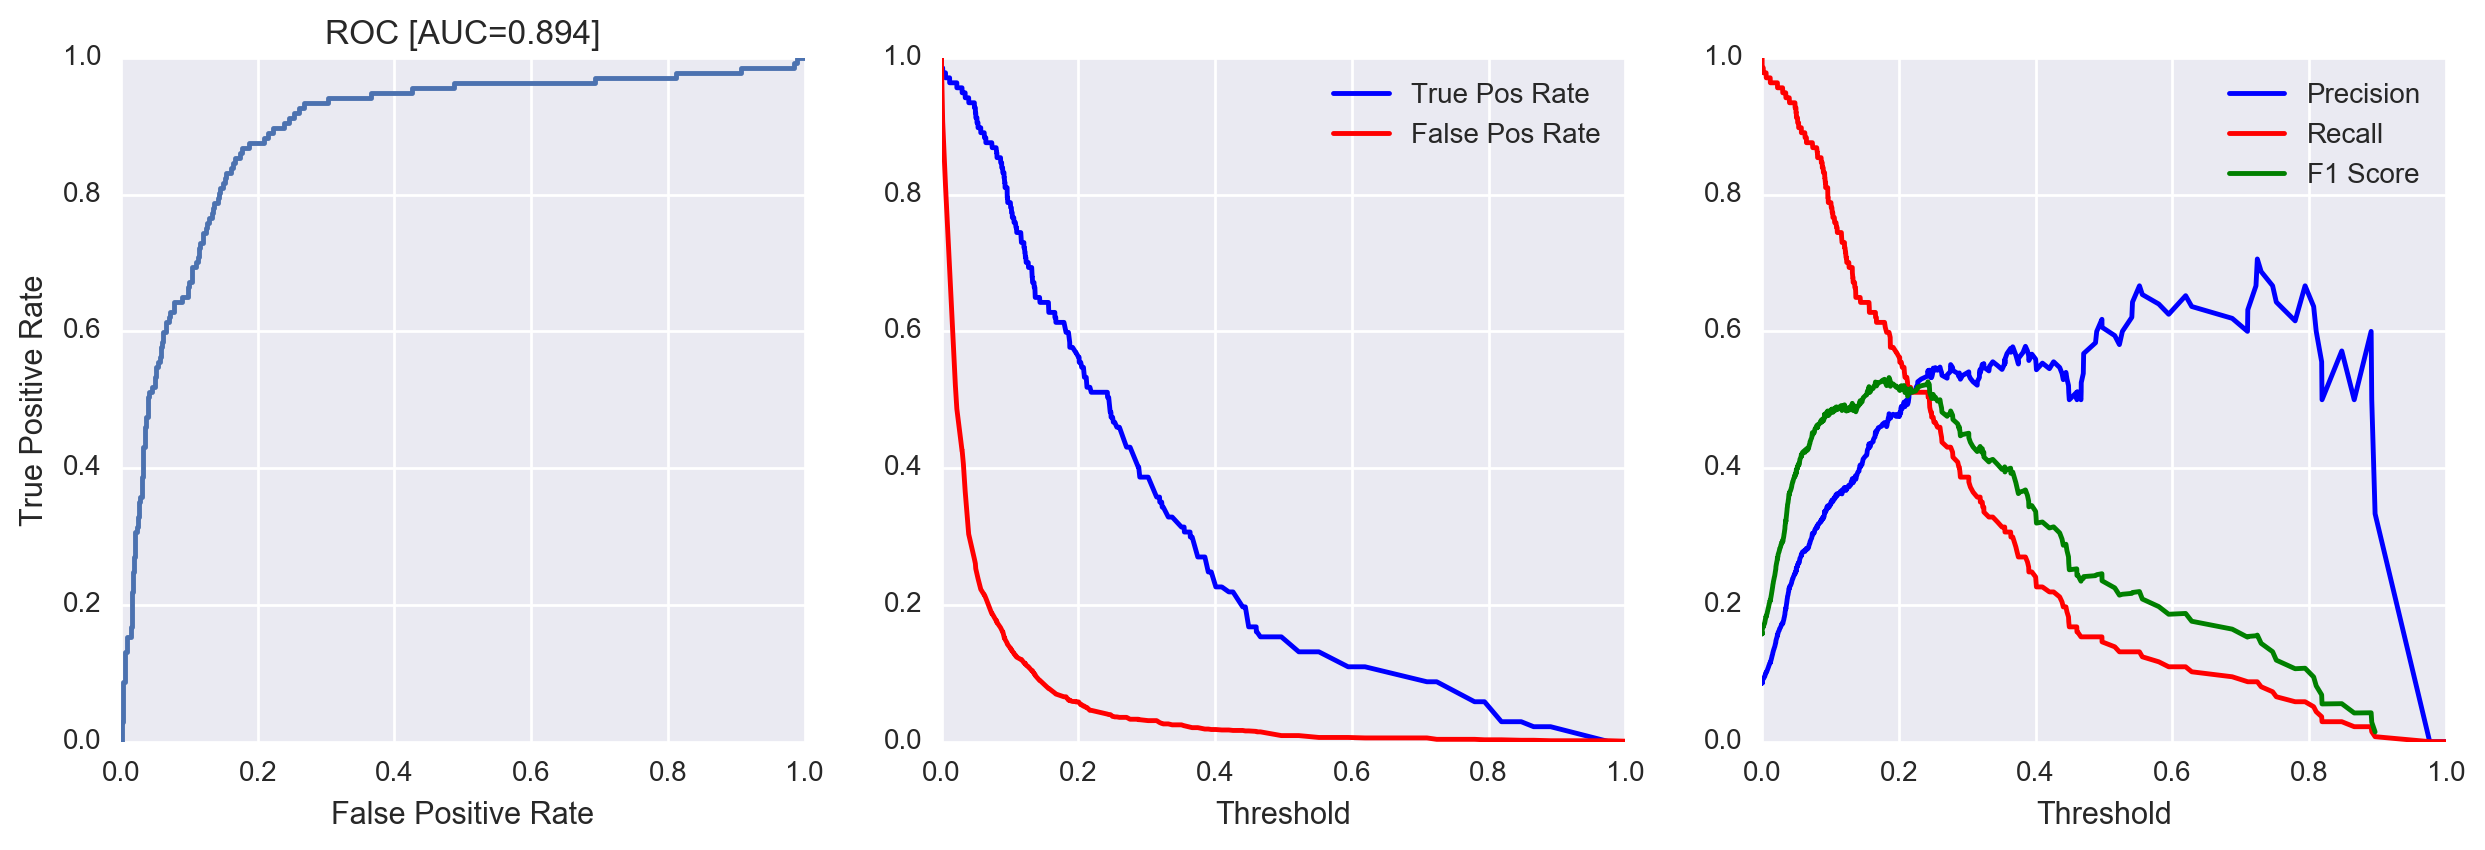

In [48]:
col = 'gender_female'
cols_to_drop = [col, 'gender_male']

val_to_keep = None

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


gender_male = 1

Dropping these columns due to fewer than 66 people having this:
 ['housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_permanenthousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (4357, 67)
test (2146, 67)

gender_male = 1

AUC: 0.91894
Precision: 0.6908
Recall: 0.3671
F1 score: 0.4795

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1813   47  1860
1            181  105   286
All         1994  152  2146

Percent of outcomes classified
Prediction          0          1
Truth                           
0           90.922768  30.921053
1            9.077232  69.078947

As feature increases, more likely to be in positive class:
                                                       coef      odds
health_insurance_statechild   

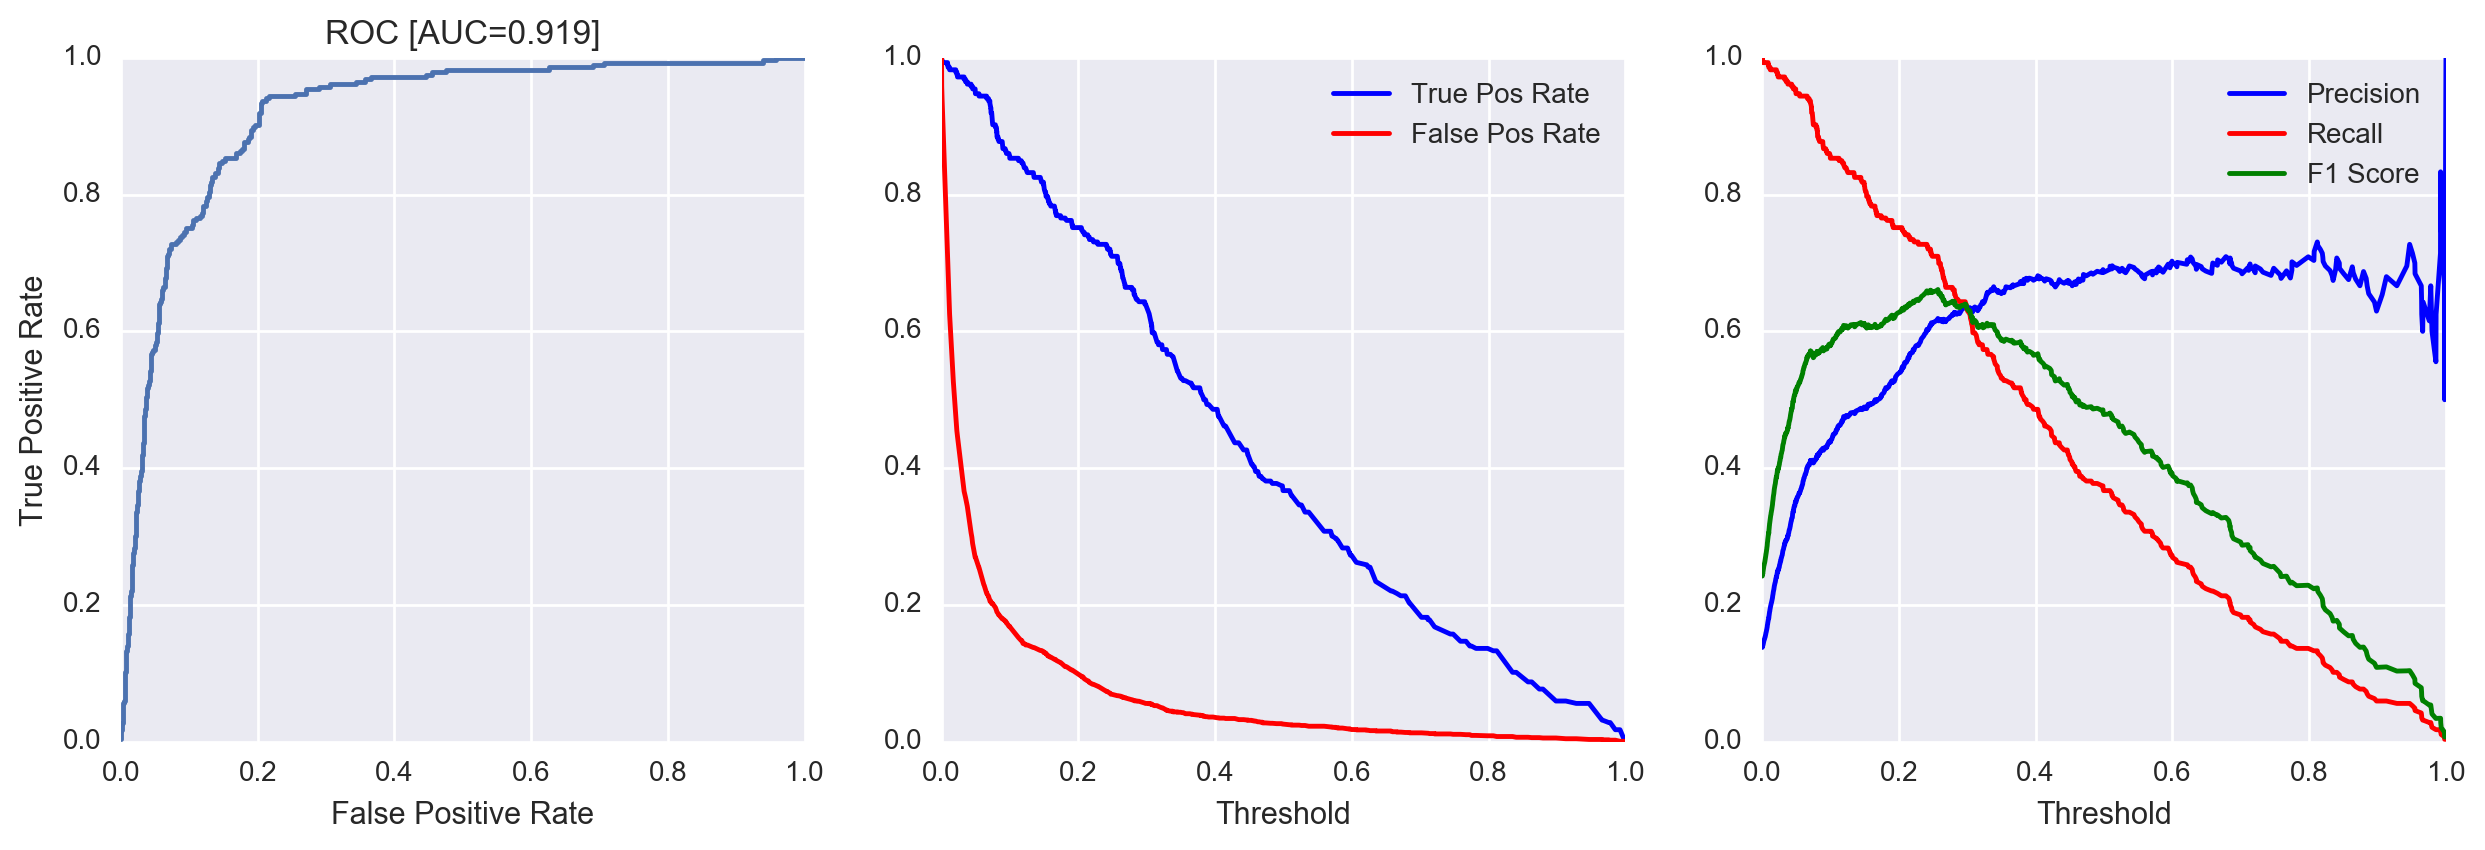

In [49]:
col = 'gender_male'
cols_to_drop = [col, 'gender_female']

val_to_keep = None

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


veteran_status = 1

Dropping these columns due to fewer than 22 people having this:
 ['housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'project_type_code_permanentsupportivehousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer', 'health_insurance_statechild', 'disability_type_hivaids']

train (1467, 64)
test (724, 64)

veteran_status = 1

AUC: 0.87286
Precision: 0.6786
Recall: 0.5429
F1 score: 0.6032

Confusion Matrix
Prediction    0    1  All
Truth                    
0           460   54  514
1            96  114  210
All         556  168  724

Percent of outcomes classified
Prediction          0          1
Truth                           
0           82.733813  32.142857
1           17.266187  67.857143

As feature 

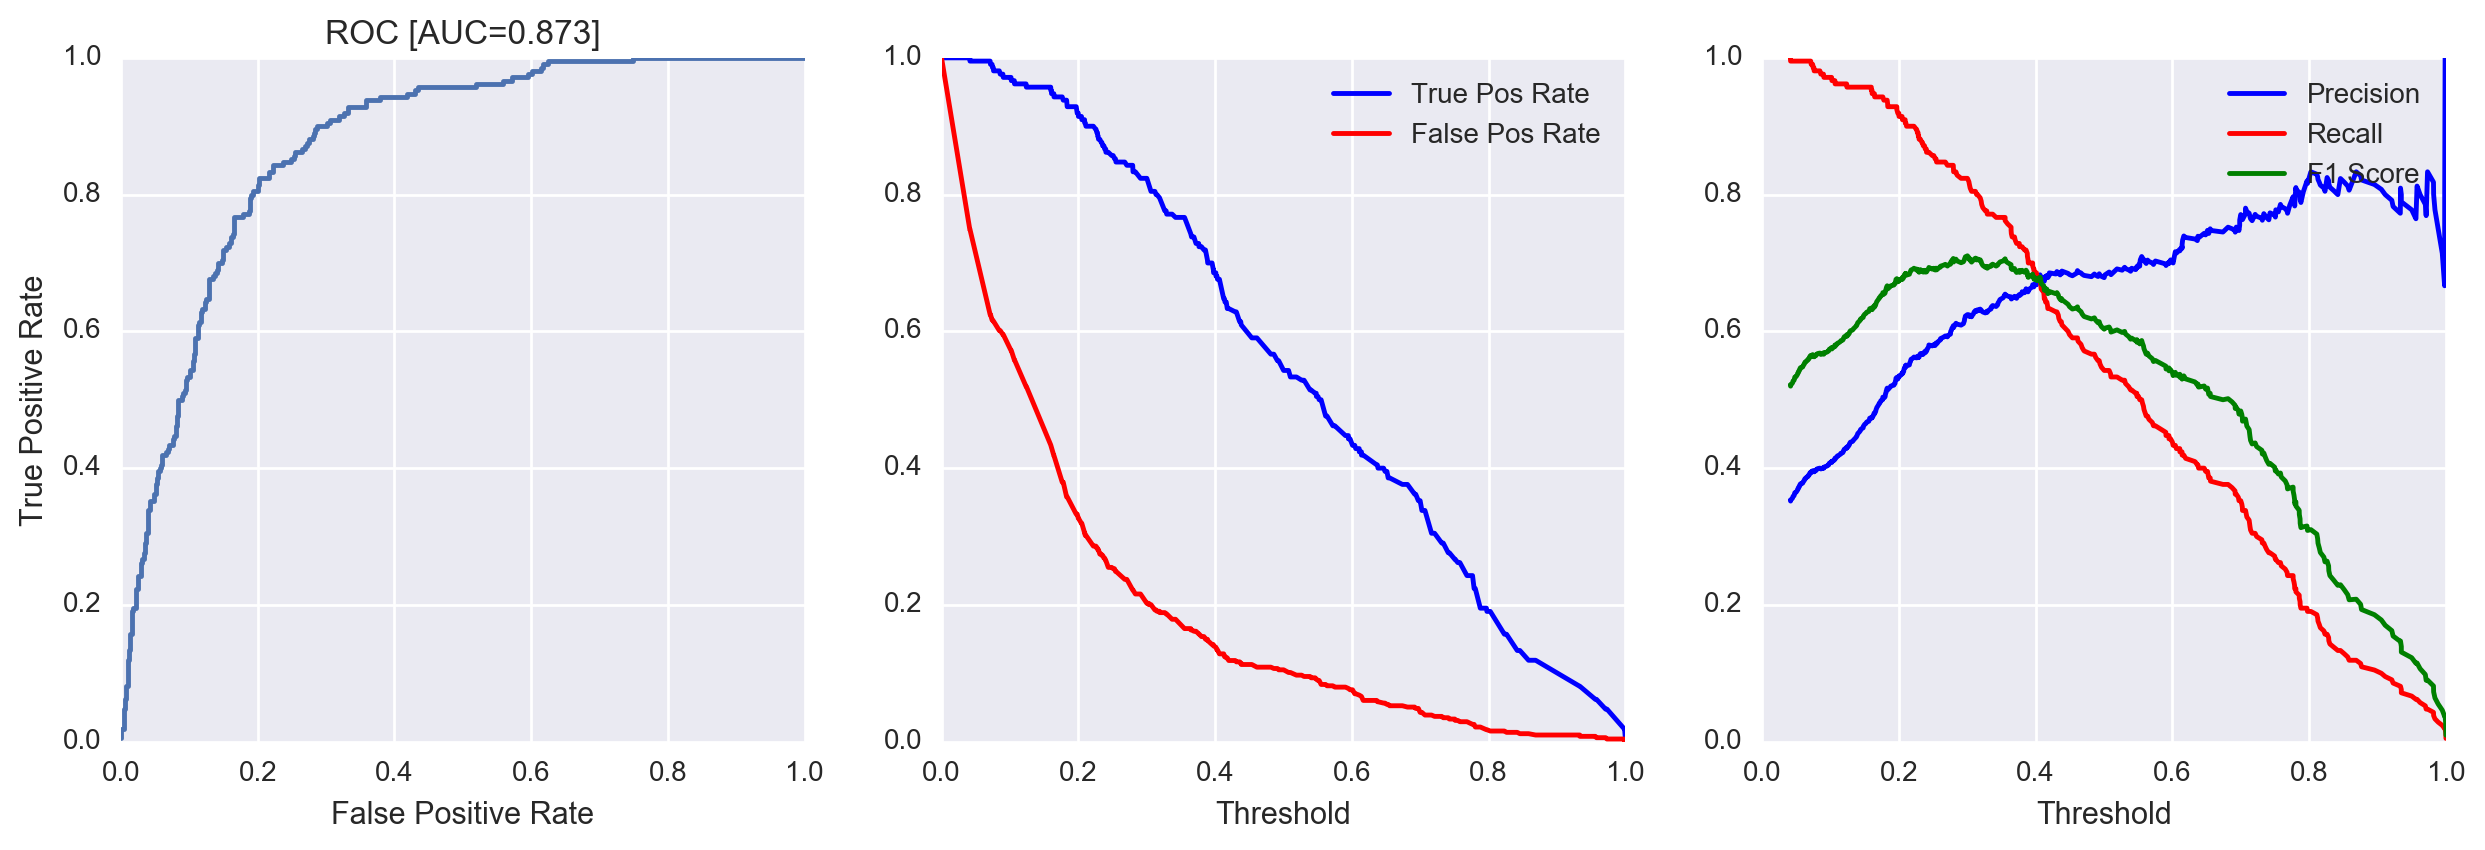

In [50]:
col = 'veteran_status'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


veteran_status = 0

Dropping these columns due to fewer than 92 people having this:
 ['living_situation_before_program_entry_foster', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'noncash_benefit_publichousing', 'health_insurance_pirvate', 'health_insurance_employer', 'health_insurance_veteranadmin']

train (6144, 68)
test (3027, 68)

veteran_status = 0

AUC: 0.86972
Precision: 0.5263
Recall: 0.1227
F1 score: 0.1990

Confusion Matrix
Prediction     0   1   All
Truth                     
0           2846  18  2864
1            143  20   163
All         2989  38  3027

Percent of outcomes classified
Prediction          0          1
Truth                           
0           95.215791  47.368421
1            4.784209  52.631579

As feature increases, more likely to be in positive class:
                                                        coef      odds
health_insurance_stateadult                         2.042771  7.711953
healt

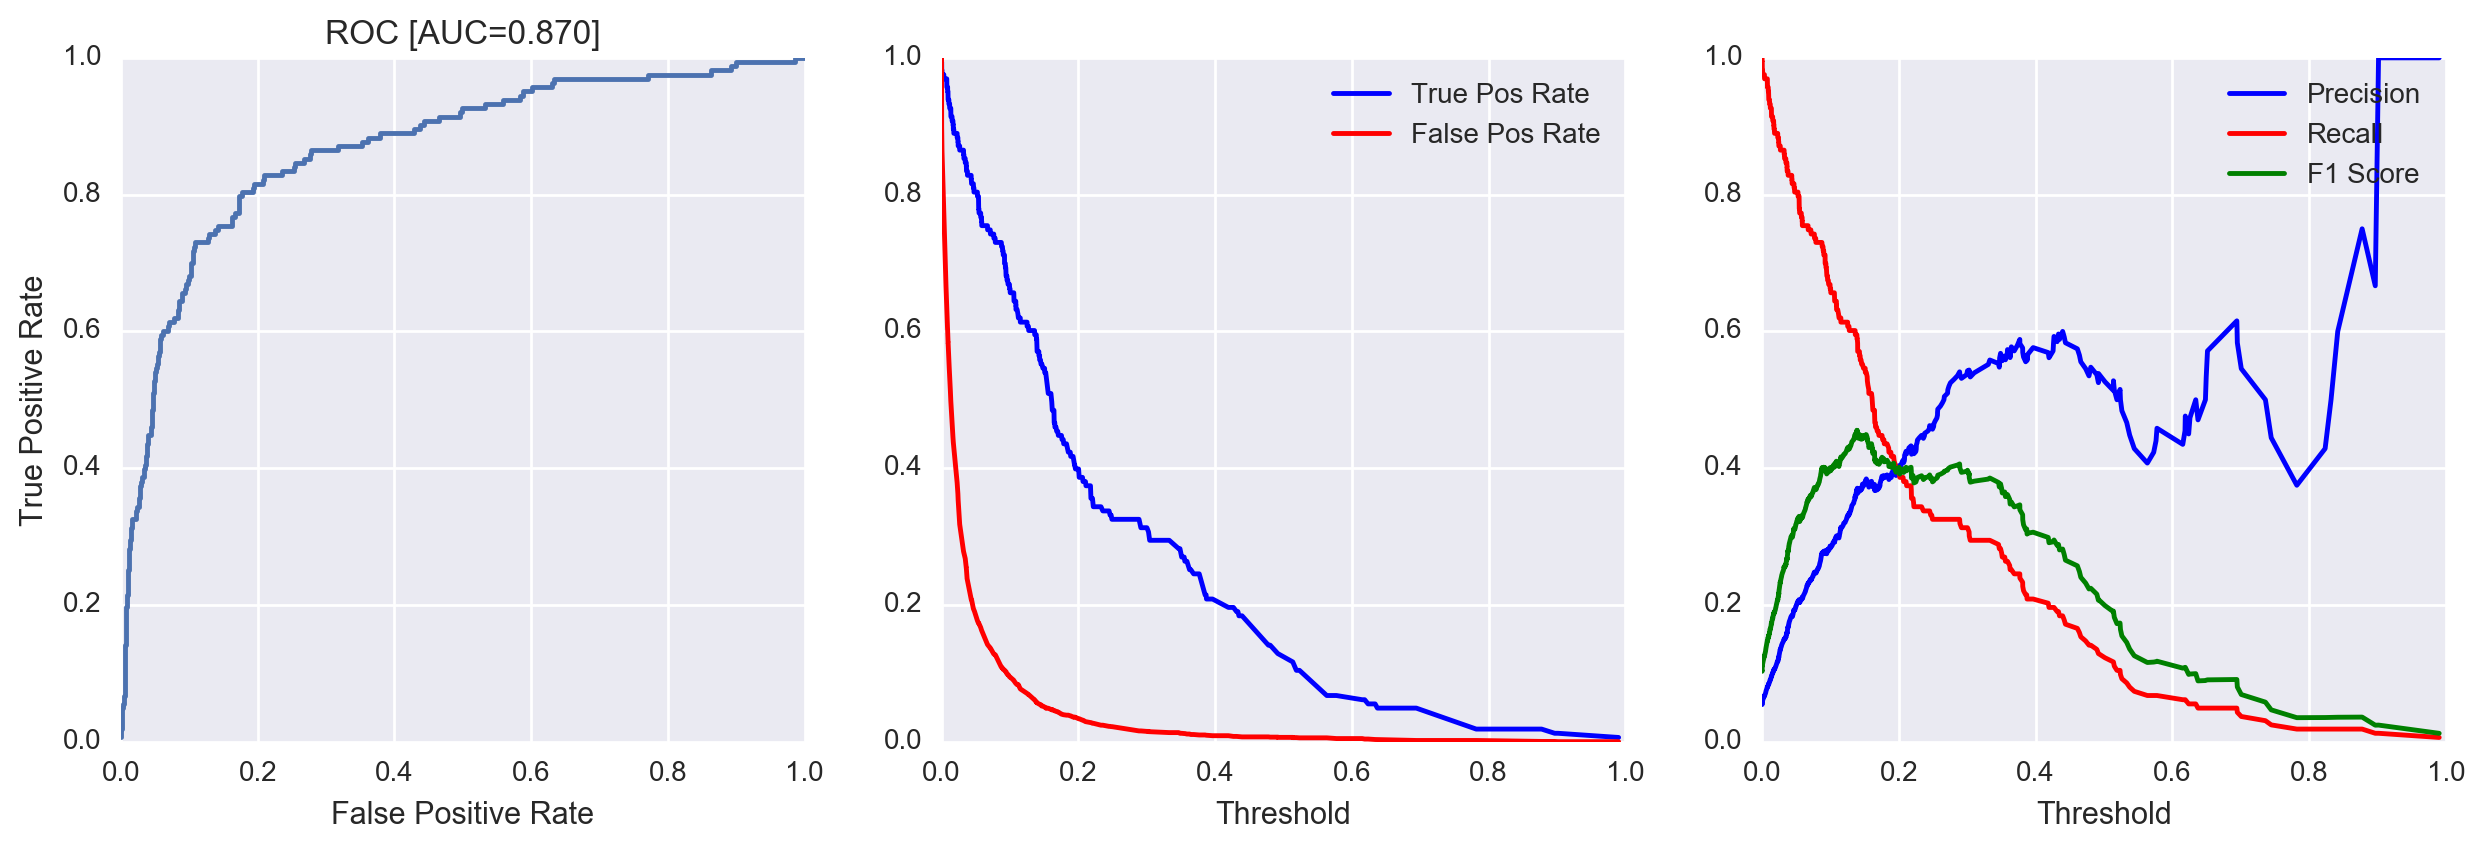

In [51]:
col = 'veteran_status'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


ethnicity_latino = 1

Dropping these columns due to fewer than 53 people having this:
 ['ethnicity_unknown', 'housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_hospitalpsych', 'race_asian', 'race_pacificisl', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'noncash_benefit_publichousing', 'health_insurance_pirvate', 'health_insurance_employer']

train (3488, 63)
test (1719, 63)

ethnicity_latino = 1

AUC: 0.90968
Precision: 0.5294
Recall: 0.3600
F1 score: 0.4286

Confusion Matrix
Prediction     0   1   All
Truth                     
0           1554  40  1594
1             80  45   125
All         1634  85  1719

Percent of outcomes classified
Prediction          0          1
Truth                           
0           95.104039  47.058824
1            4.895961  52.941176

As feature increases, more likely to be in positive class:
           

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


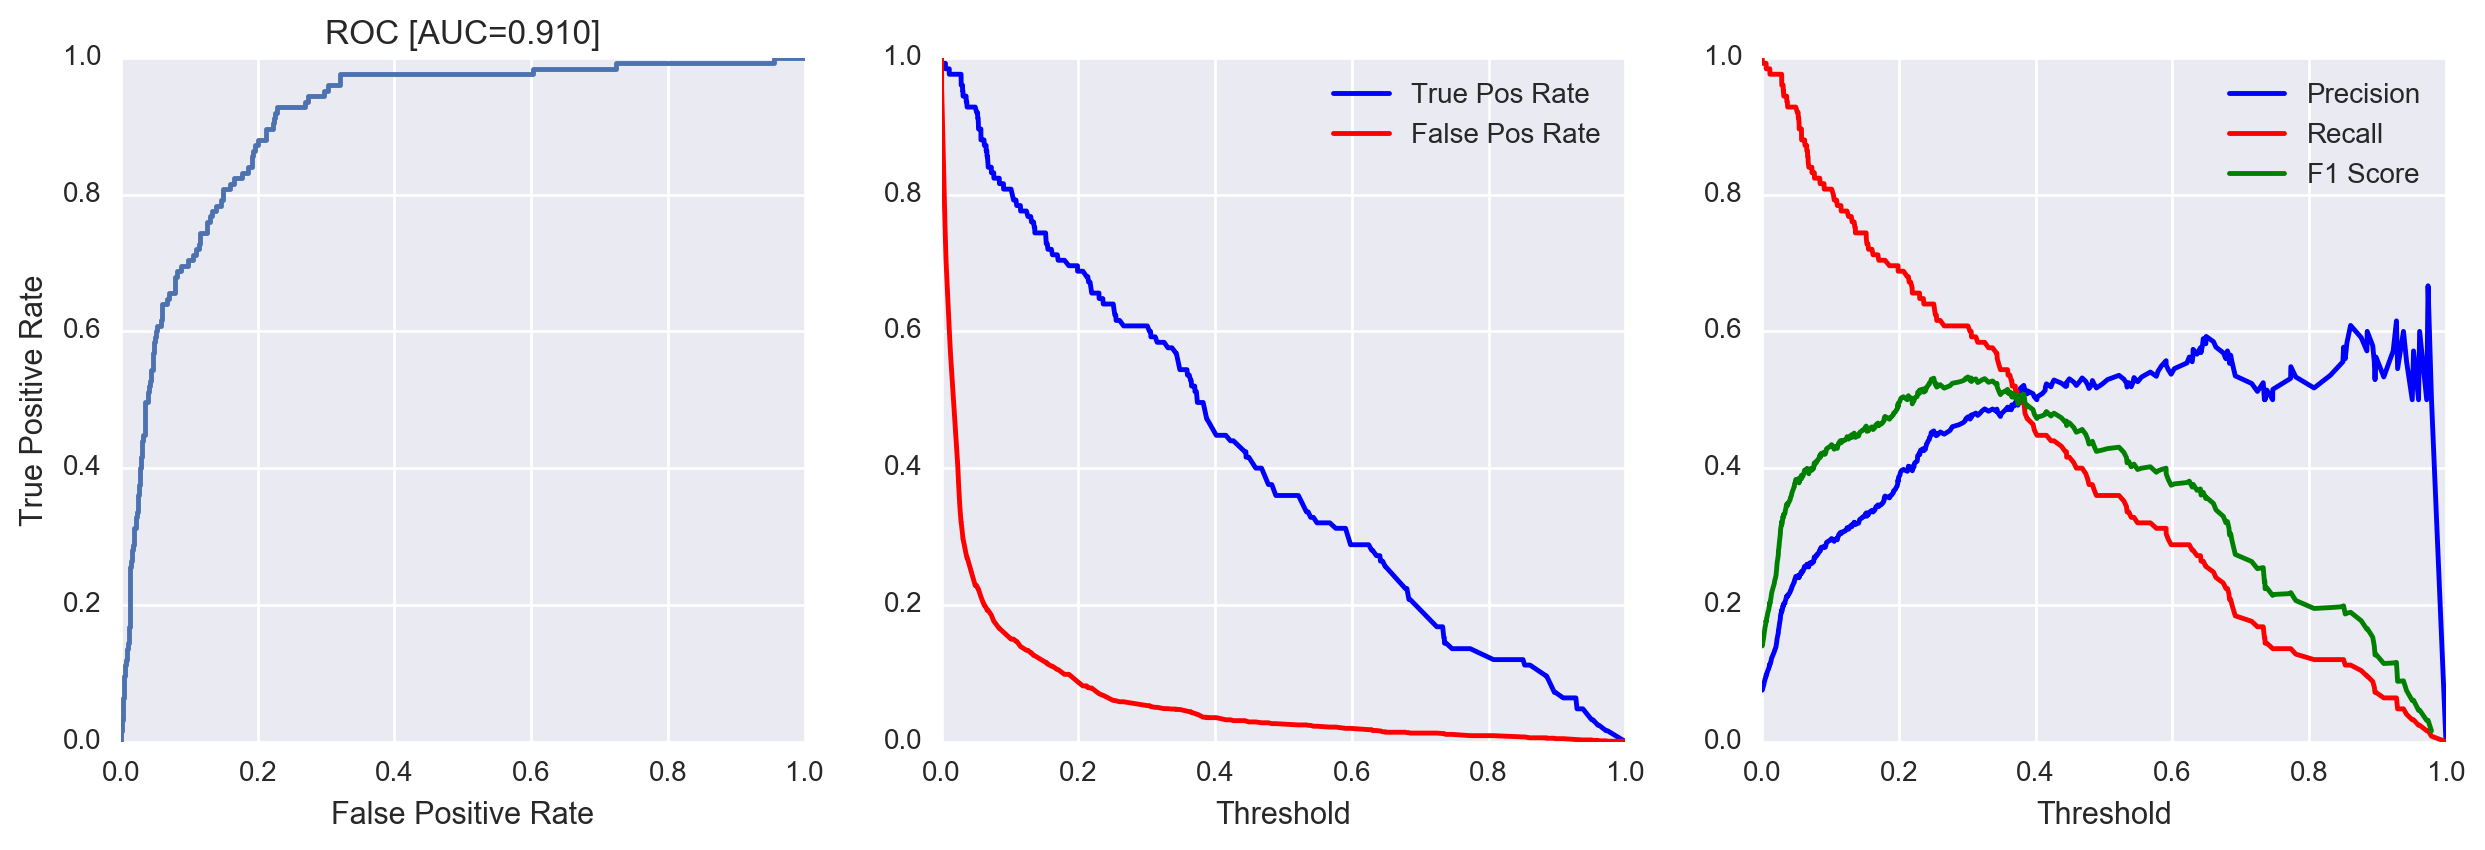

In [52]:
col = 'ethnicity_latino'
cols_to_drop = [col, 'ethnicity_nonlatino']

val_to_keep = None

results, myLR, y = predict_group(df_features_num,
                                 col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


ethnicity_nonlatino = 1

Dropping these columns due to fewer than 60 people having this:
 ['ethnicity_unknown', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'race_unknown', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation']

train (3972, 67)
test (1957, 67)

ethnicity_nonlatino = 1

AUC: 0.91241
Precision: 0.6987
Recall: 0.4241
F1 score: 0.5278

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1653   47  1700
1            148  109   257
All         1801  156  1957

Percent of outcomes classified
Prediction          0          1
Truth                           
0           91.782343  30.128205
1            8.217657  69.871795

As feature increases, more likely to be in positive class:
                                                  coef      odds
project_type_code_rapidrehousing              1.

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


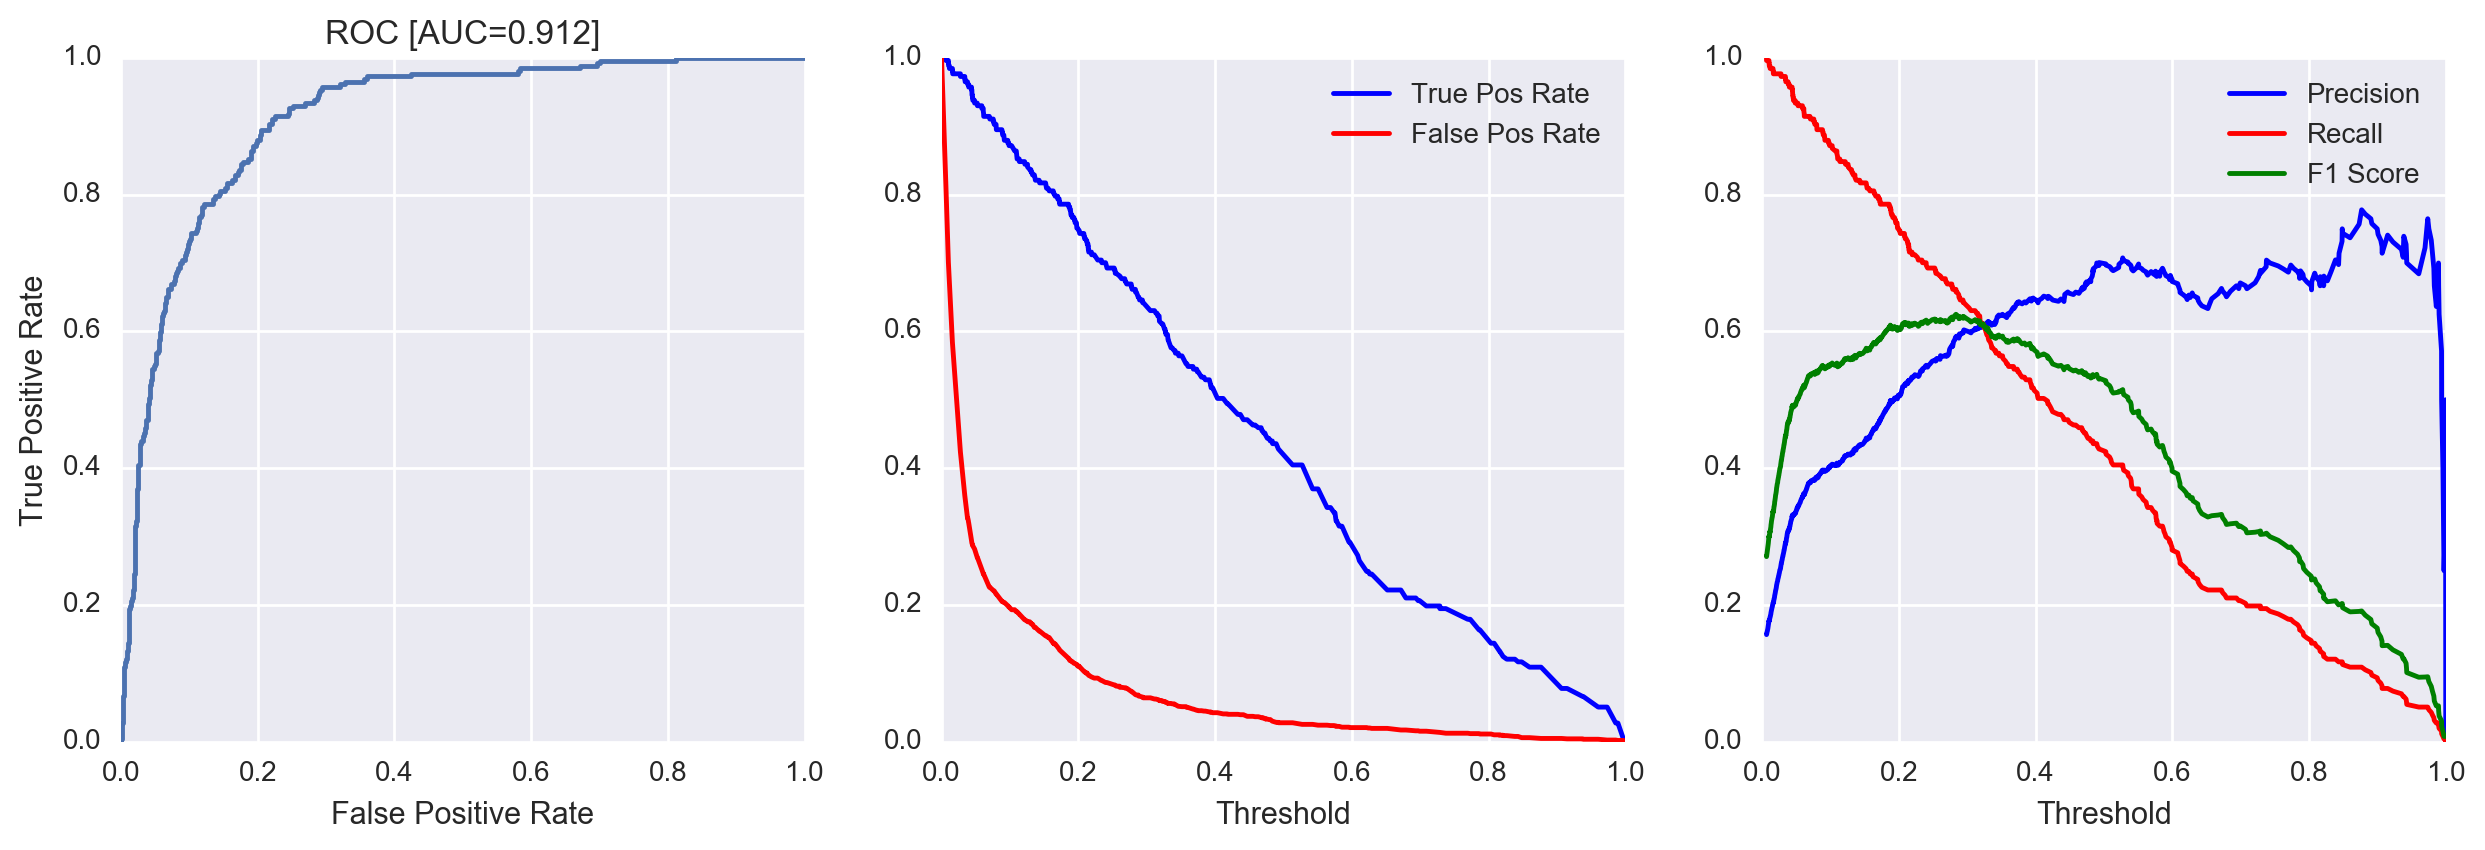

In [53]:
col = 'ethnicity_nonlatino'
cols_to_drop = [col, 'ethnicity_latino']

val_to_keep = None

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


chronic_homeless = 1

Dropping these columns due to fewer than 7 people having this:
 ['living_situation_before_program_entry_foster', 'living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'living_situation_before_program_entry_rentalother', 'noncash_benefit_tanfchildcare', 'health_insurance_employer', 'health_insurance_statechild']

train (455, 69)
test (225, 69)

chronic_homeless = 1

AUC: 0.95624
Precision: 0.7097
Recall: 0.7333
F1 score: 0.7213

Confusion Matrix
Prediction    0   1  All
Truth                   
0           186   9  195
1             8  22   30
All         194  31  225

Percent of outcomes classified
Prediction          0          1
Truth                           
0           95.876289  29.032258
1            4.123711  70.967742

As feature increases, more likely to be in positive class:
                                                        coef      odds
noncash_benefit_publichousing                       1.601

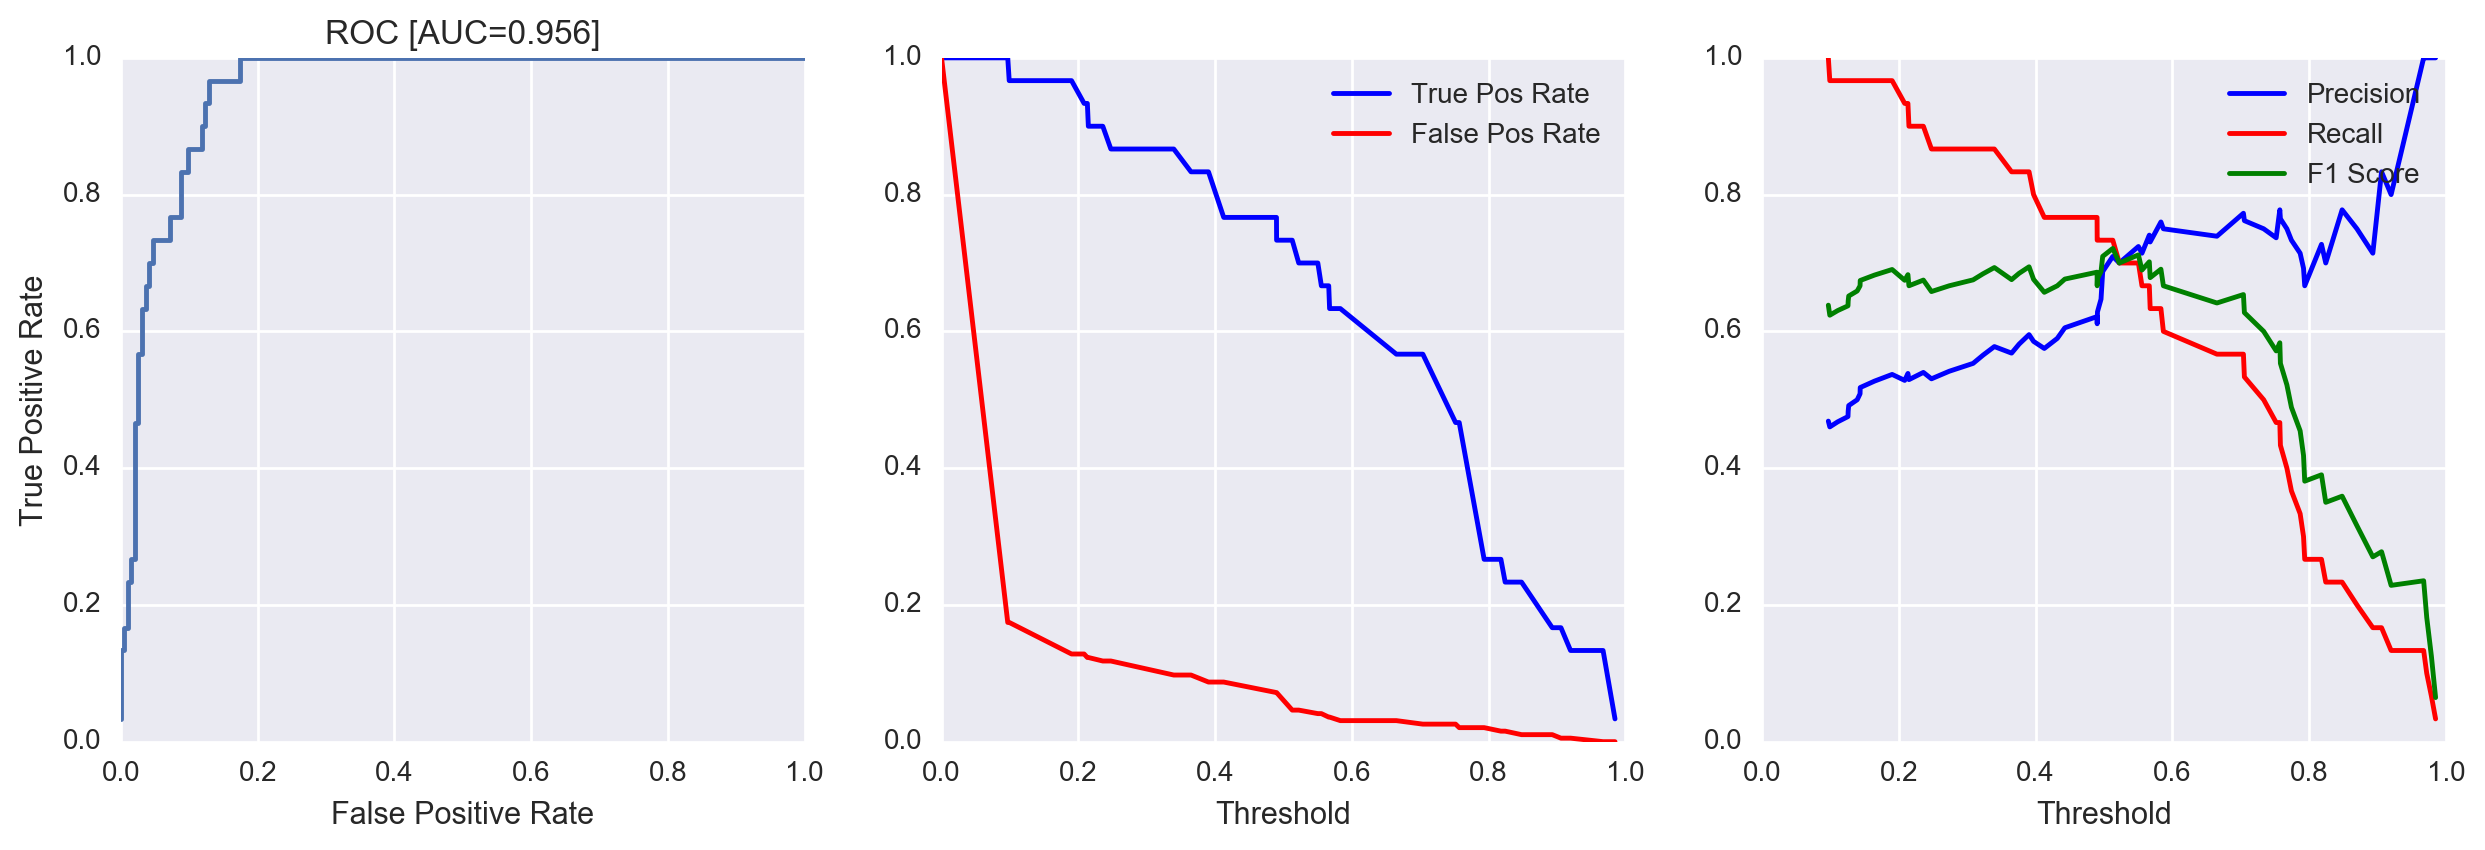

In [54]:
col = 'chronic_homeless'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


chronic_homeless = 0

Dropping these columns due to fewer than 107 people having this:
 ['housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (7156, 69)
test (3526, 69)

chronic_homeless = 0

AUC: 0.89591
Precision: 0.6190
Recall: 0.3493
F1 score: 0.4466

Confusion Matrix
Prediction     0    1   All
Truth                      
0           3119   72  3191
1            218  117   335
All         3337  189  3526

Percent of outcomes classified
Prediction          0          1
Truth                           
0           93.467186  38.095238
1            6.532814  61.904762

As feature increases, more likely to be in positive class:
                                                       coef      odds
health_insurance_stateadult                        1.568680  4.800310
noncash

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


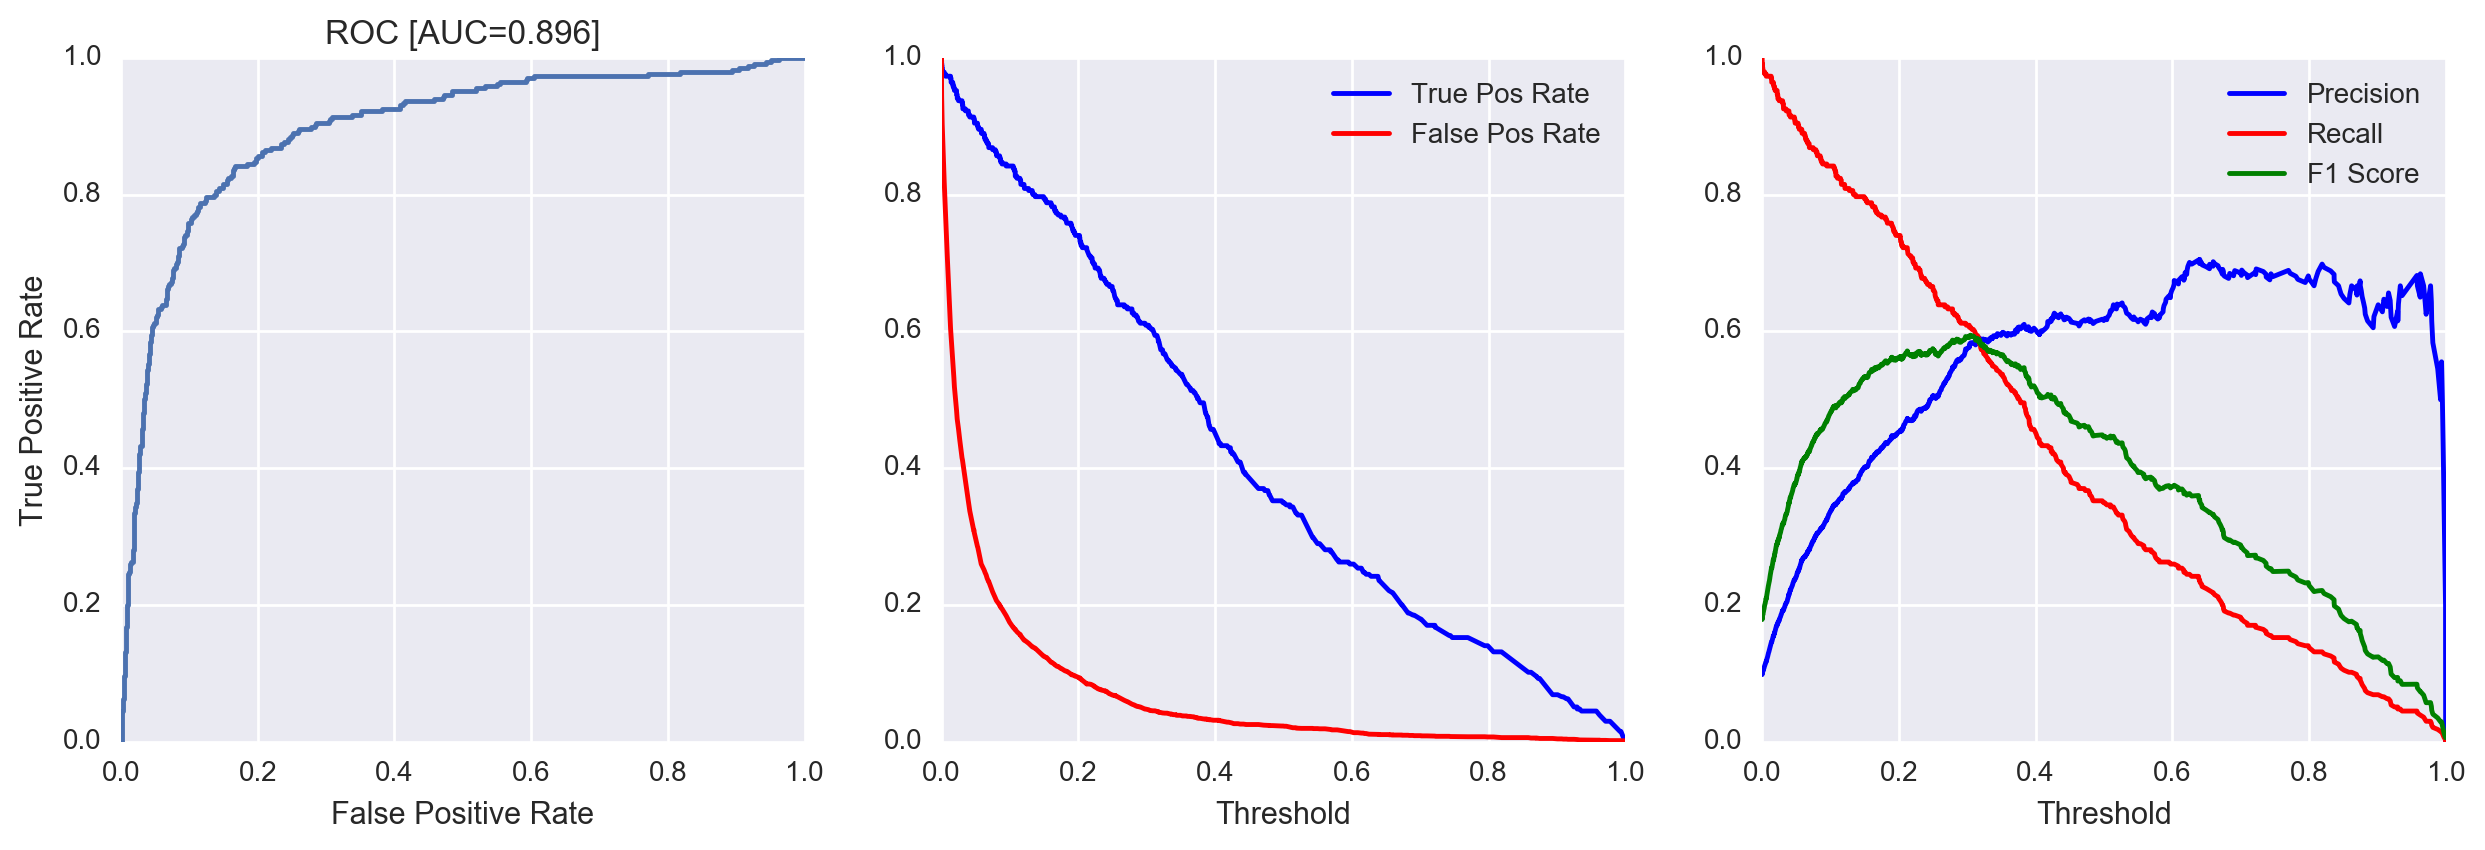

In [55]:
col = 'chronic_homeless'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


continuously_homeless_one_year = 1

Dropping these columns due to fewer than 22 people having this:
 ['living_situation_before_program_entry_owned', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (1411, 70)
test (696, 70)

continuously_homeless_one_year = 1

AUC: 0.90463
Precision: 0.6044
Recall: 0.5238
F1 score: 0.5612

Confusion Matrix
Prediction    0   1  All
Truth                   
0           555  36  591
1            50  55  105
All         605  91  696

Percent of outcomes classified
Prediction          0         1
Truth                          
0           91.735537  39.56044
1            8.264463  60.43956

As feature increases, more likely to be in positive class:
                                                        coef      odds
project_type_code_rapidrehousing                    1.798062  6.037936
veteran_status                                      1.4

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


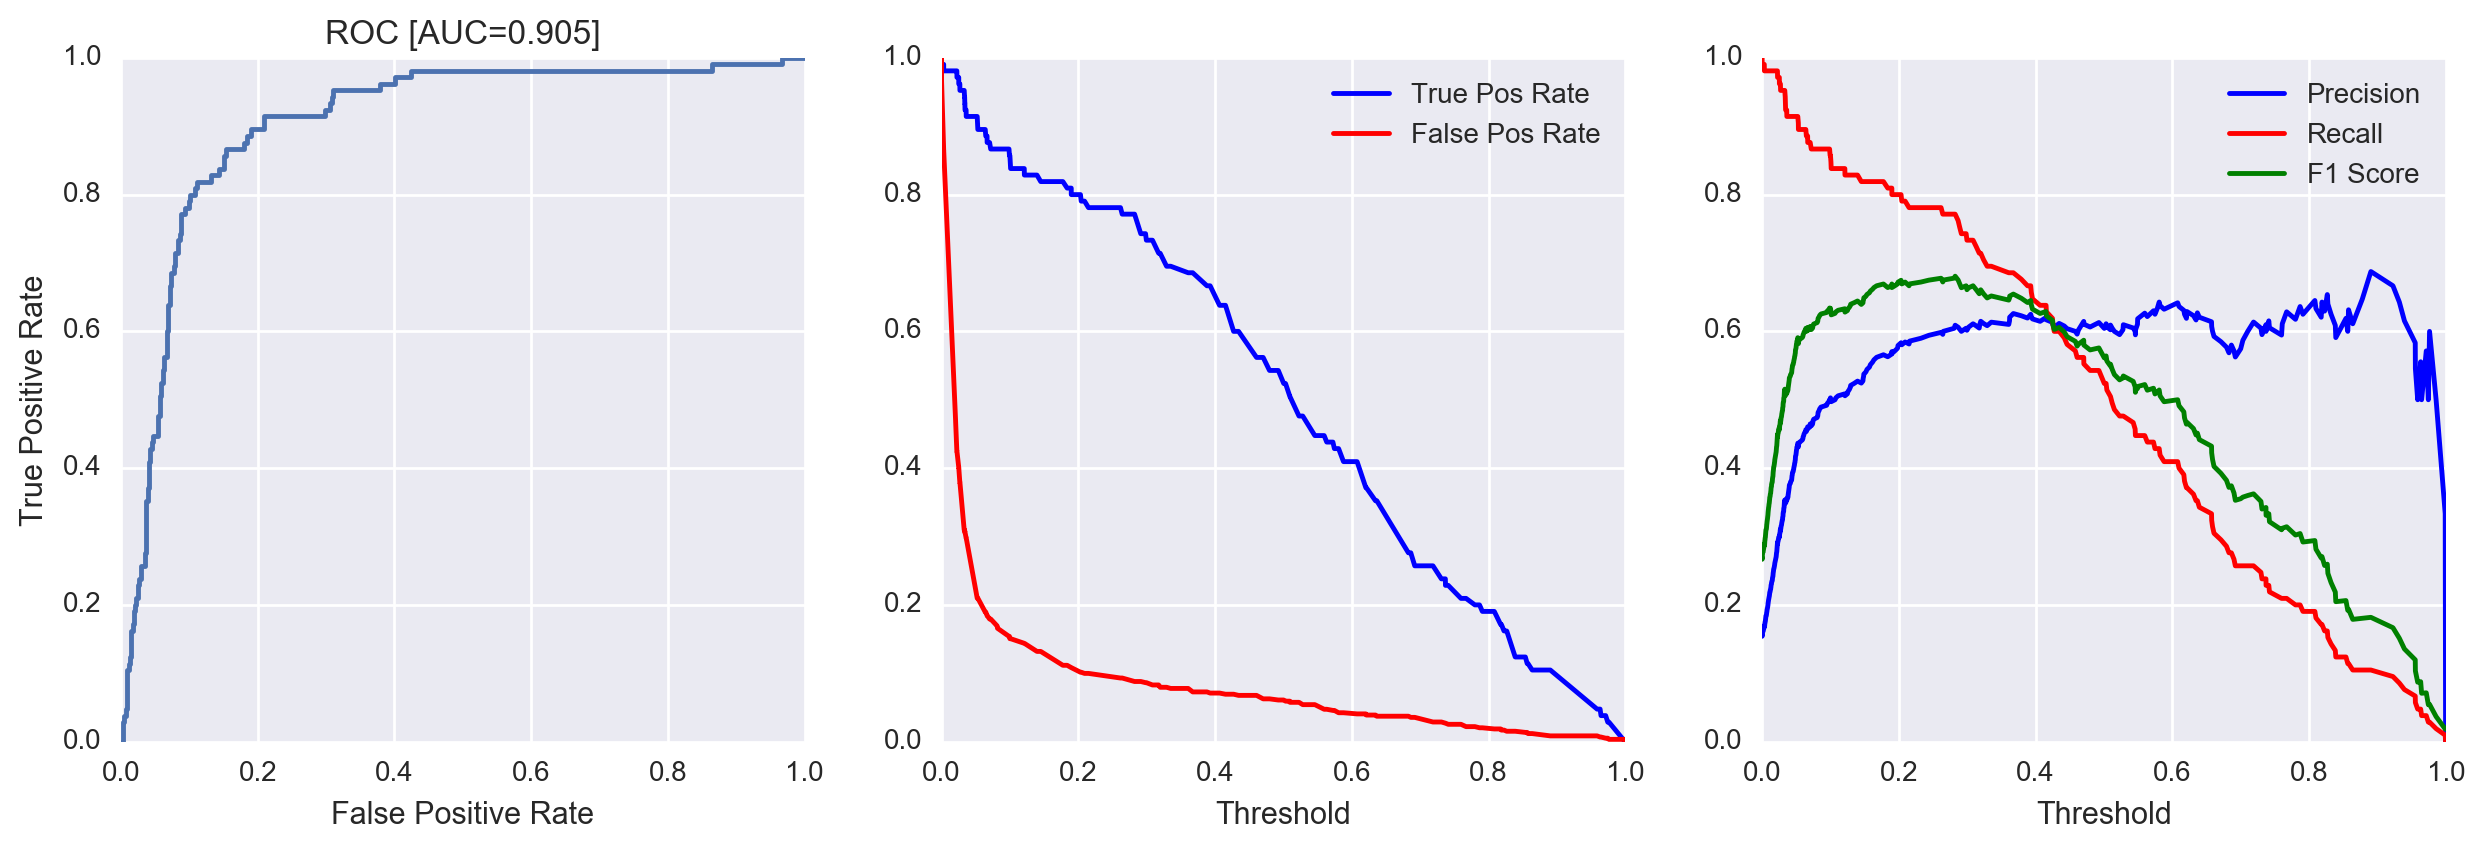

In [56]:
col = 'continuously_homeless_one_year'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


continuously_homeless_one_year = 0

Dropping these columns due to fewer than 93 people having this:
 ['chronic_homeless', 'housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (6200, 68)
test (3055, 68)

continuously_homeless_one_year = 0

AUC: 0.91270
Precision: 0.6739
Recall: 0.3310
F1 score: 0.4439

Confusion Matrix
Prediction     0    1   All
Truth                      
0           2729   45  2774
1            188   93   281
All         2917  138  3055

Percent of outcomes classified
Prediction          0          1
Truth                           
0           93.555022  32.608696
1            6.444978  67.391304

As feature increases, more likely to be in positive class:
                                                        coef      odds
health_insurance_stateadult  

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


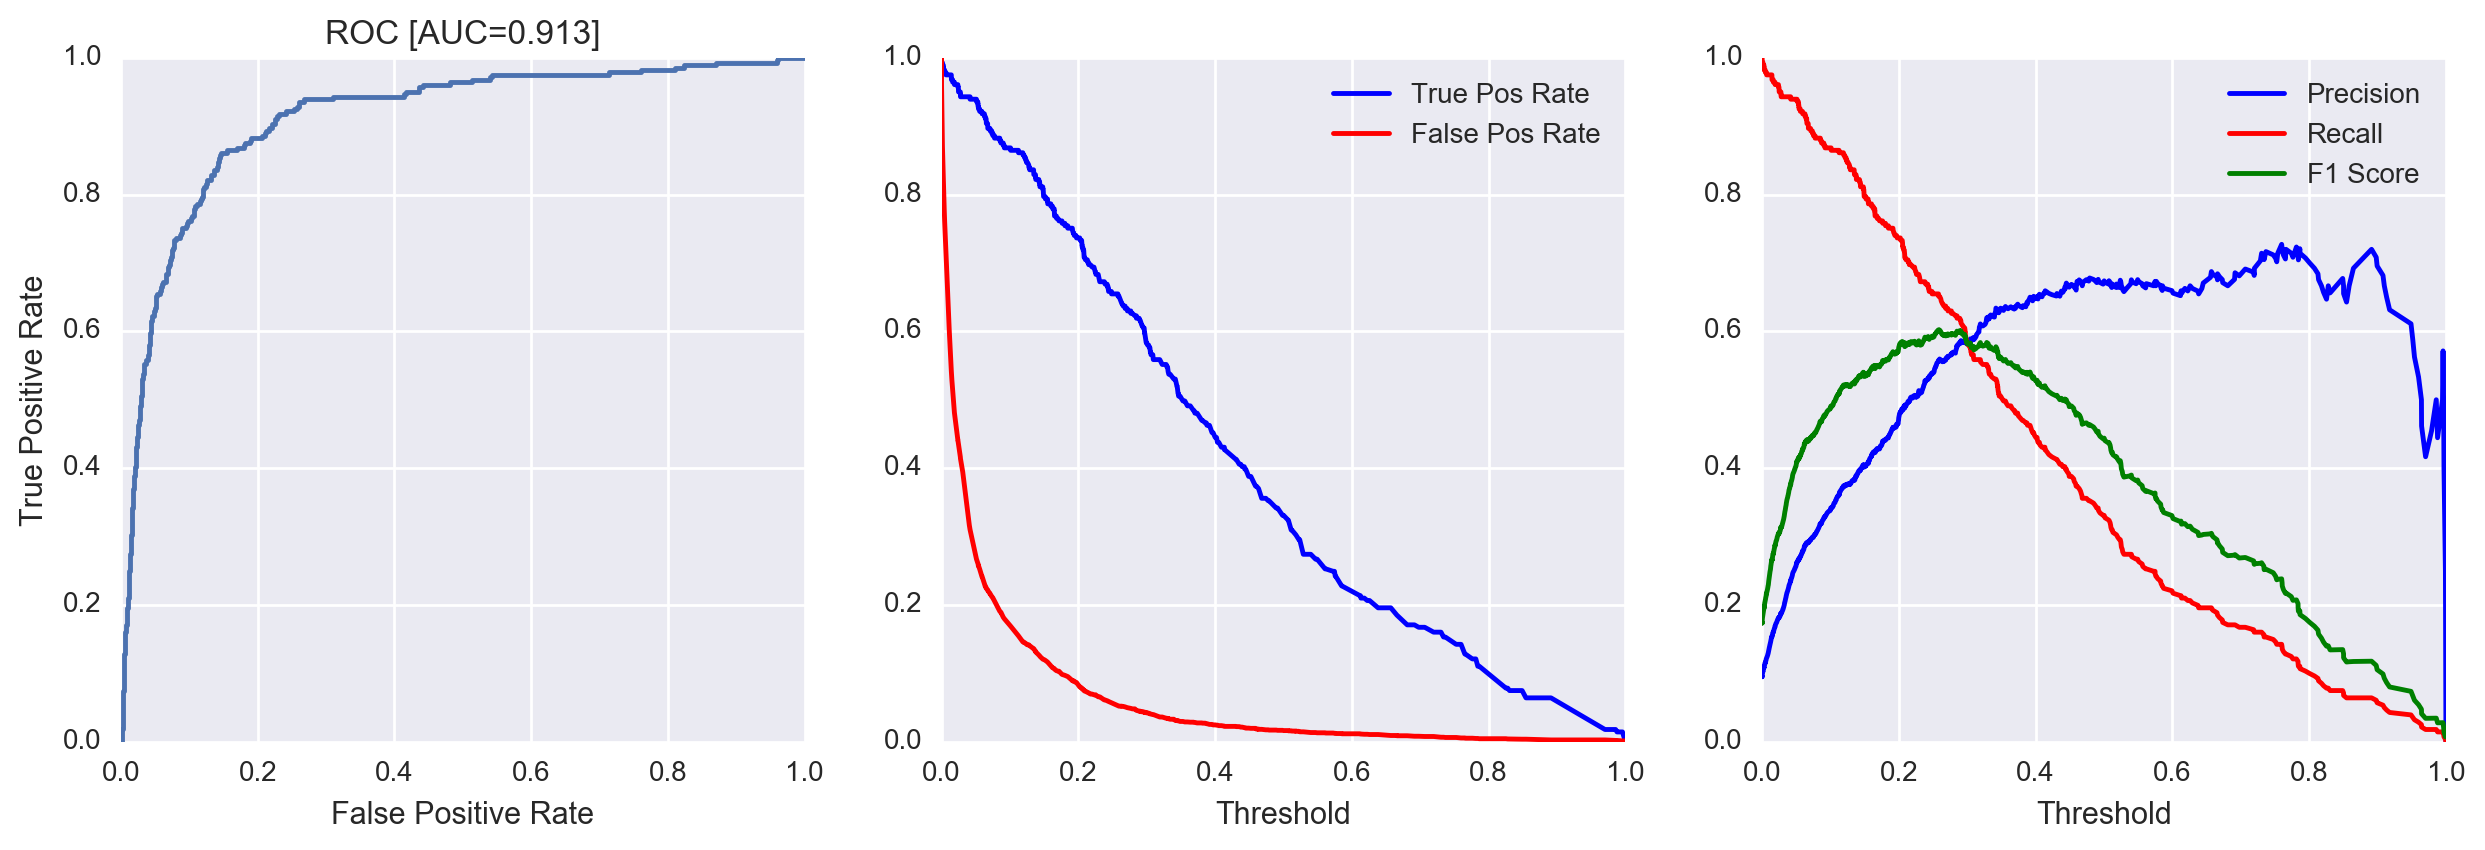

In [57]:
col = 'continuously_homeless_one_year'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


disabling_condition = 1

Dropping these columns due to fewer than 45 people having this:
 ['living_situation_before_program_entry_foster', 'living_situation_before_program_entry_permanenthousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_statechild']

train (2972, 70)
test (1465, 70)

disabling_condition = 1

AUC: 0.92551
Precision: 0.7500
Recall: 0.4352
F1 score: 0.5508

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1244   28  1272
1            109   84   193
All         1353  112  1465

Percent of outcomes classified
Prediction          0     1
Truth                      
0           91.943829  25.0
1            8.056171  75.0

As feature increases, more likely to be in positive class:
                                                  coef      odds
project_type_code_rapidrehousing              1.166931  3.212119
veteran_status                                0.975928  

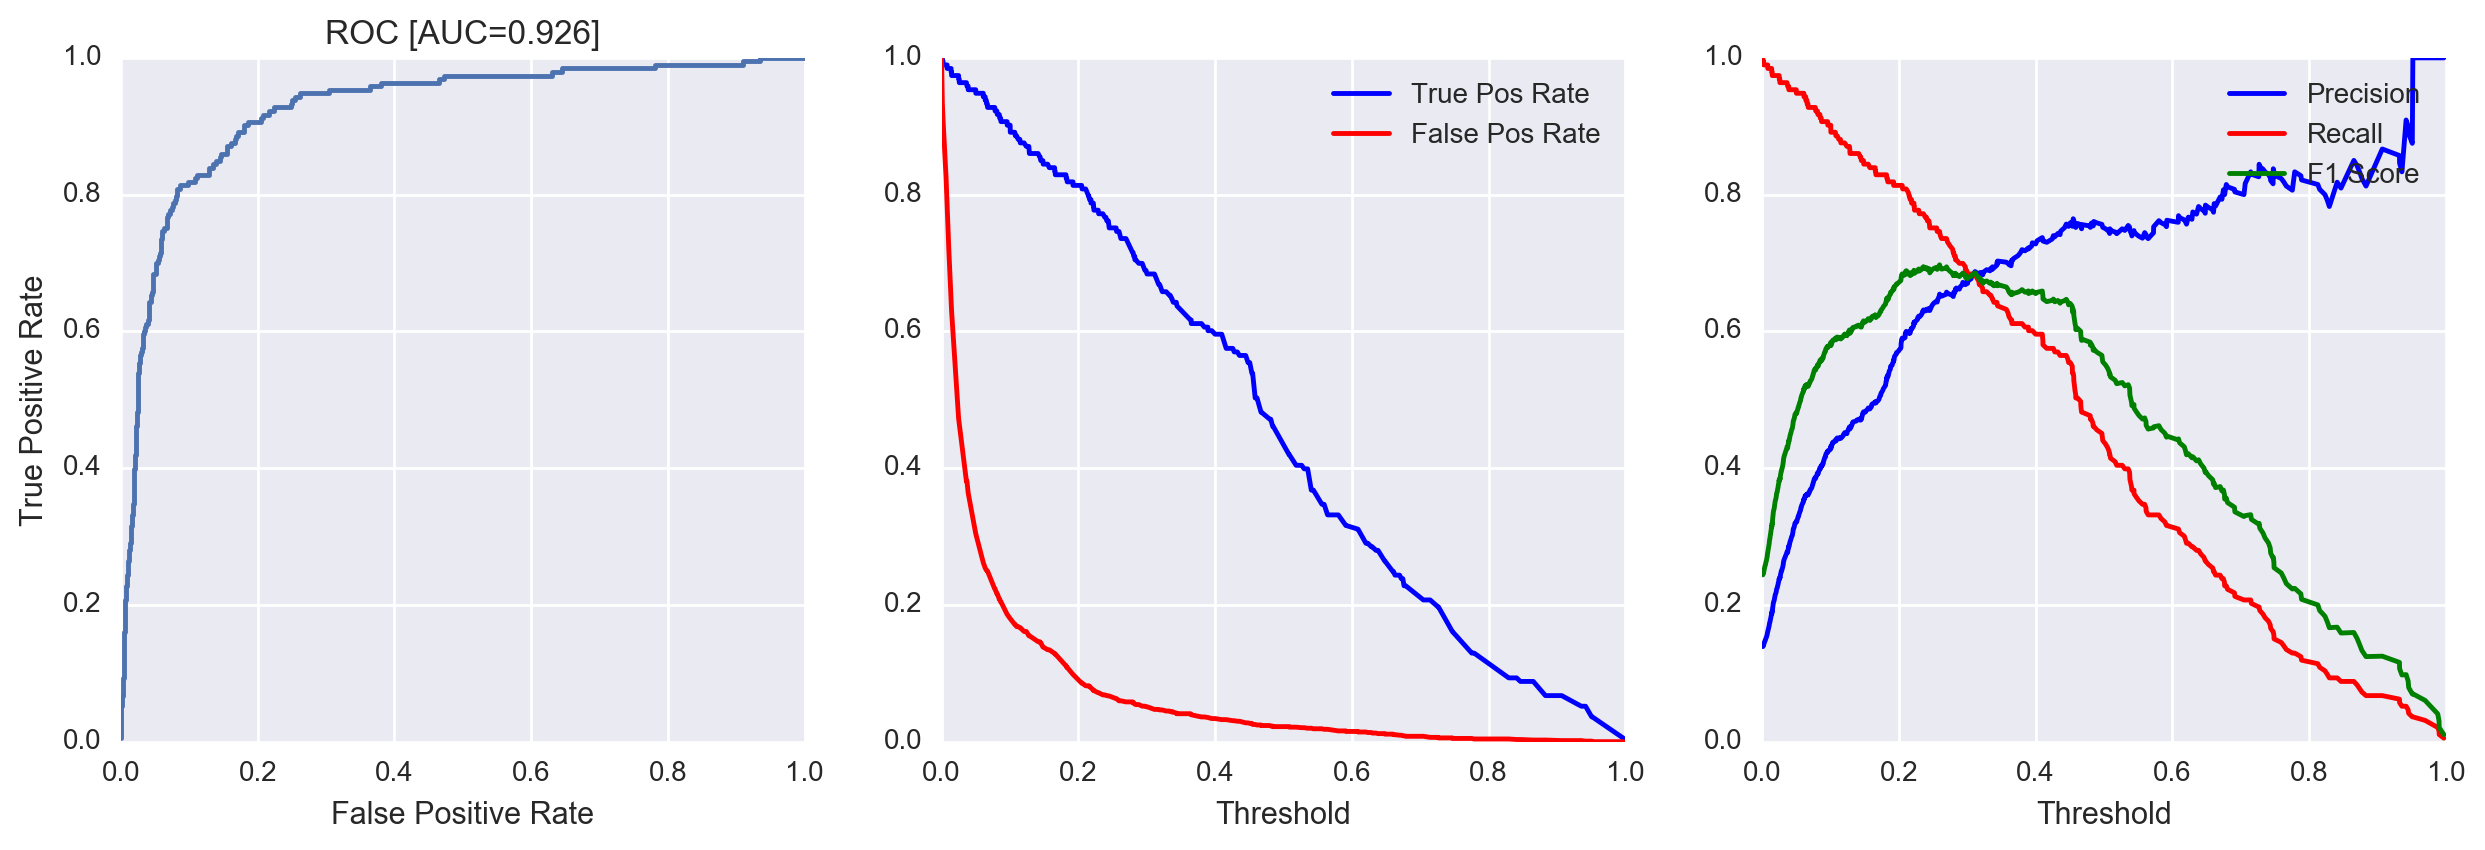

In [58]:
col = 'disabling_condition'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


disabling_condition = 0

Dropping these columns due to fewer than 70 people having this:
 ['chronic_homeless', 'housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_hospitalpsych', 'living_situation_before_program_entry_owned', 'project_type_code_permanentsupportivehousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'noncash_benefit_publichousing', 'health_insurance_pirvate', 'health_insurance_employer', 'disability_type_hivaids', 'disability_type_alcoholdrug', 'disability_type_developmental', 'disability_type_physical', 'disability_type_chronichealth', 'disability_type_alcohol', 'disability_type_drug']

train (4639, 57)
test (2286, 57)

disabling_condition = 0

AUC: 0.90145
Precision: 0.6063
Recall: 0.4140
F1 score: 0.4920

Confusion Matrix
Prediction     0    1   All
Truth                      
0           2050   50  2100
1            109

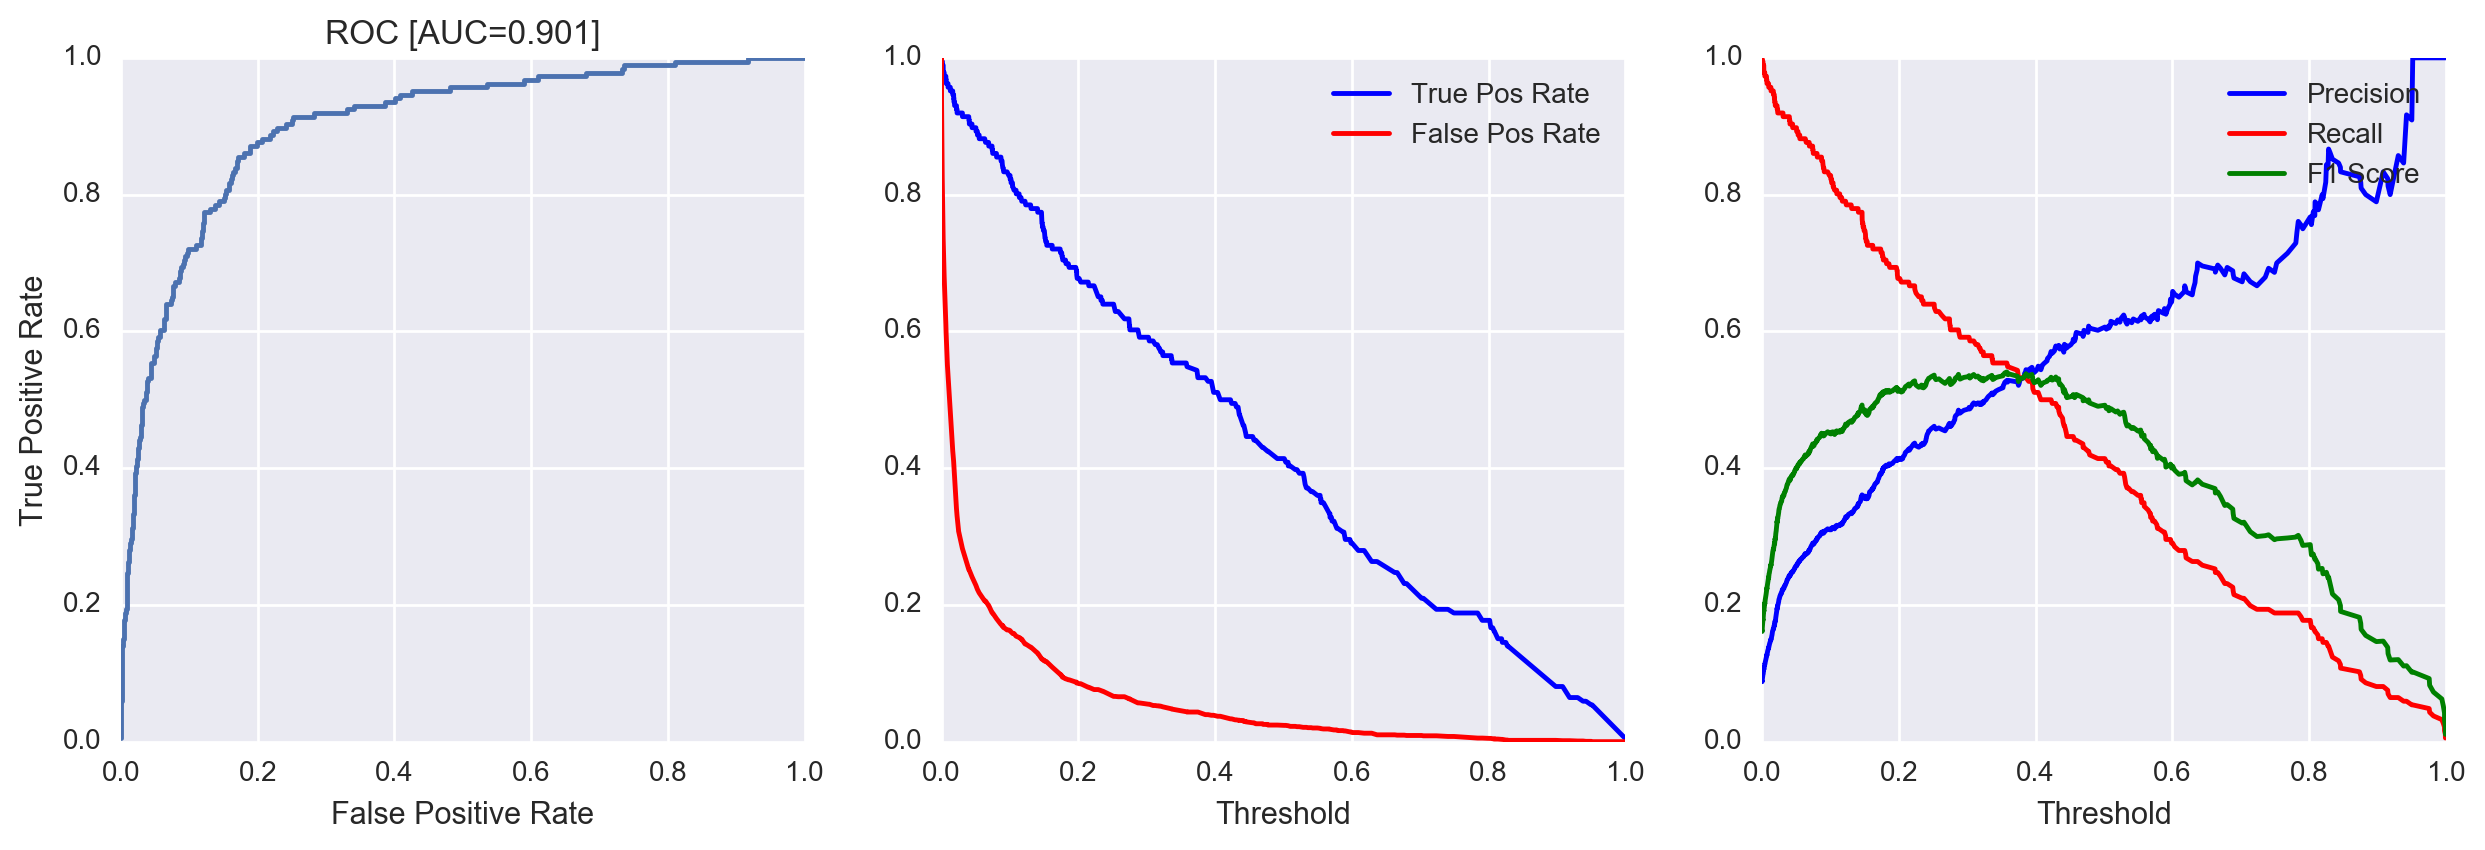

In [59]:
col = 'disabling_condition'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


domestic_violence_victim = 1

Dropping these columns due to fewer than 21 people having this:
 ['living_situation_before_program_entry_owned', 'noncash_benefit_tanfother', 'health_insurance_pirvate', 'disability_type_hivaids']

train (1394, 72)
test (687, 72)

domestic_violence_victim = 1

AUC: 0.91842
Precision: 0.5556
Recall: 0.3125
F1 score: 0.4000

Confusion Matrix
Prediction    0   1  All
Truth                   
0           647   8  655
1            22  10   32
All         669  18  687

Percent of outcomes classified
Prediction         0          1
Truth                          
0           96.71151  44.444444
1            3.28849  55.555556

As feature increases, more likely to be in positive class:
                                                        coef      odds
project_type_code_rapidrehousing                    1.689694  5.417821
veteran_status                                      1.365063  3.915971
living_situation_before_program_entry_rentalvash    1.136394  3.11551

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


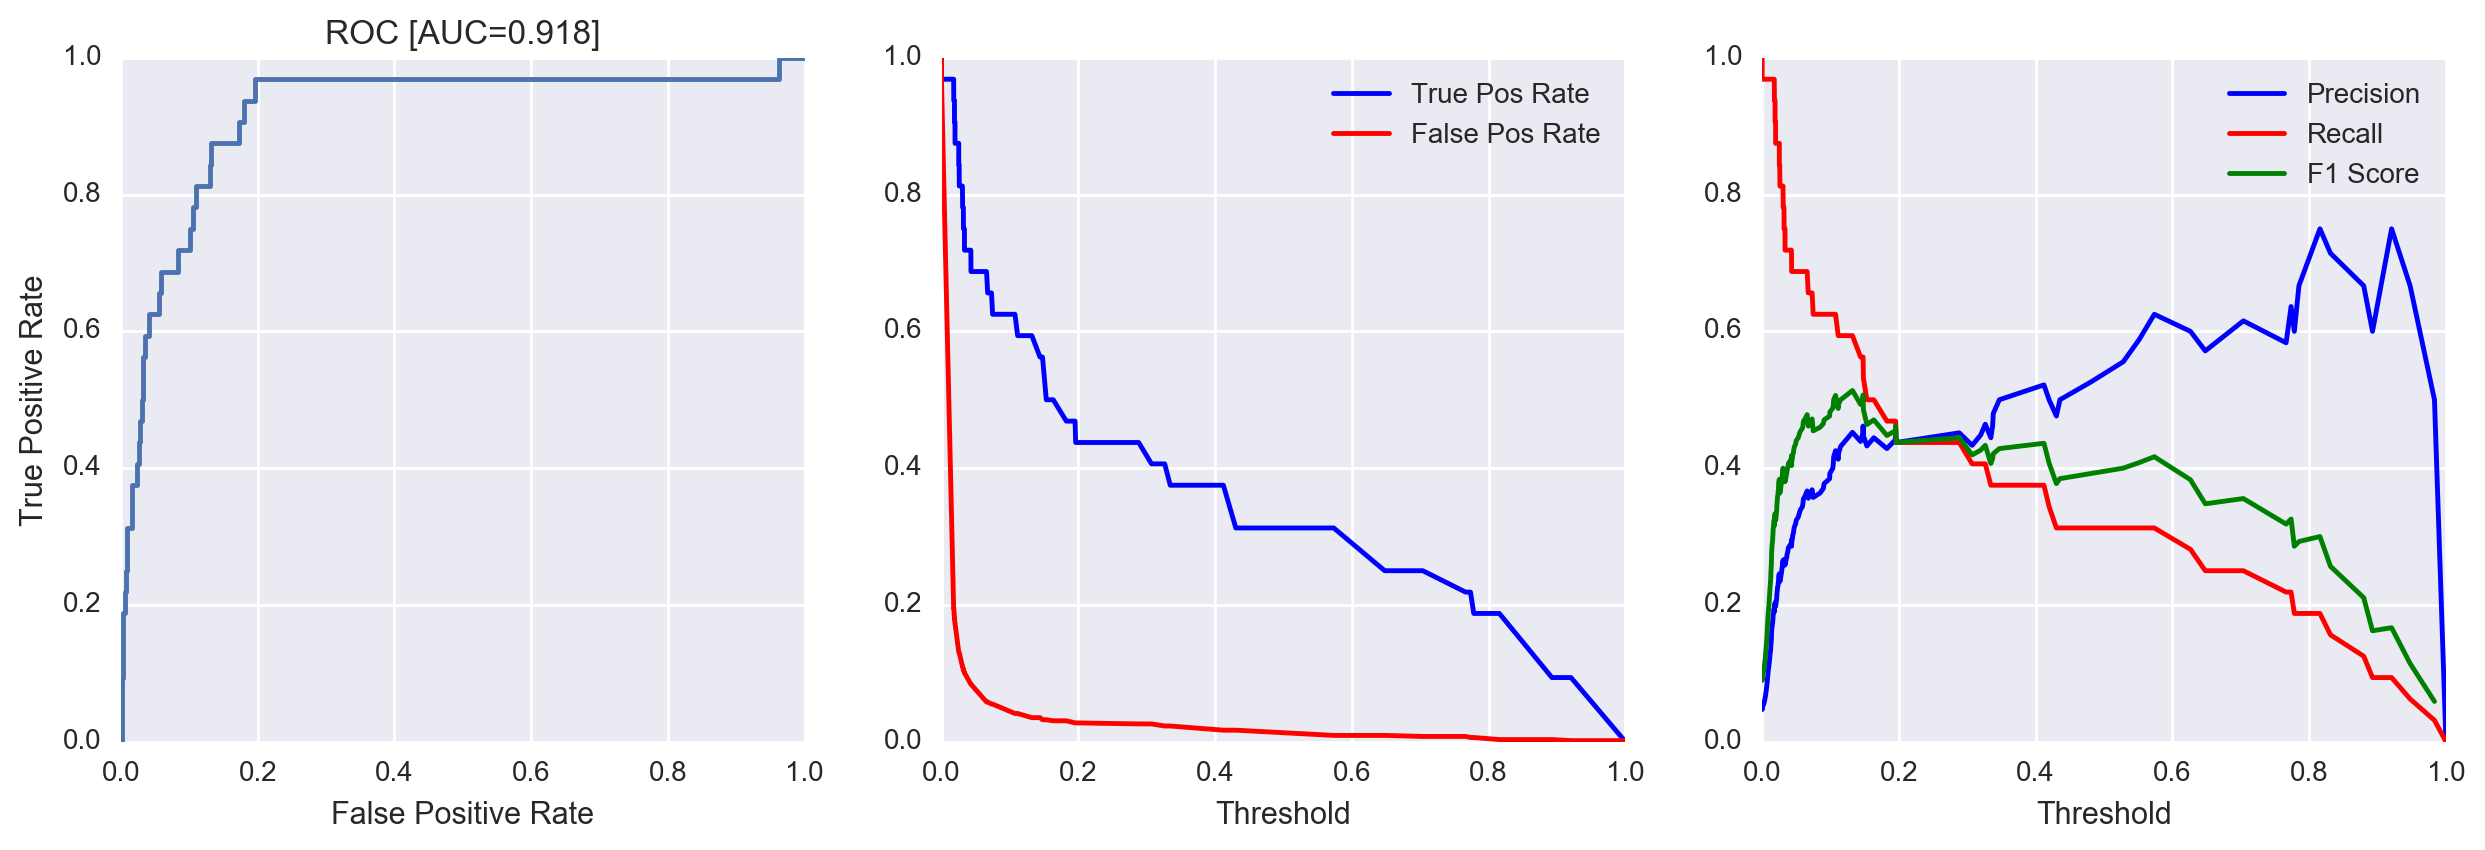

In [60]:
col = 'domestic_violence_victim'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


domestic_violence_victim = 0

Dropping these columns due to fewer than 93 people having this:
 ['housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_permanenthousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (6218, 68)
test (3063, 68)

domestic_violence_victim = 0

AUC: 0.90759
Precision: 0.6513
Recall: 0.3713
F1 score: 0.4730

Confusion Matrix
Prediction     0    1   All
Truth                      
0           2653   68  2721
1            215  127   342
All         2868  195  3063

Percent of outcomes classified
Prediction          0          1
Truth                           
0           92.503487  34.871795
1            7.496513  65.128205

As feature increases, more likely to be in positive class:
                                                       coef      odds
heal

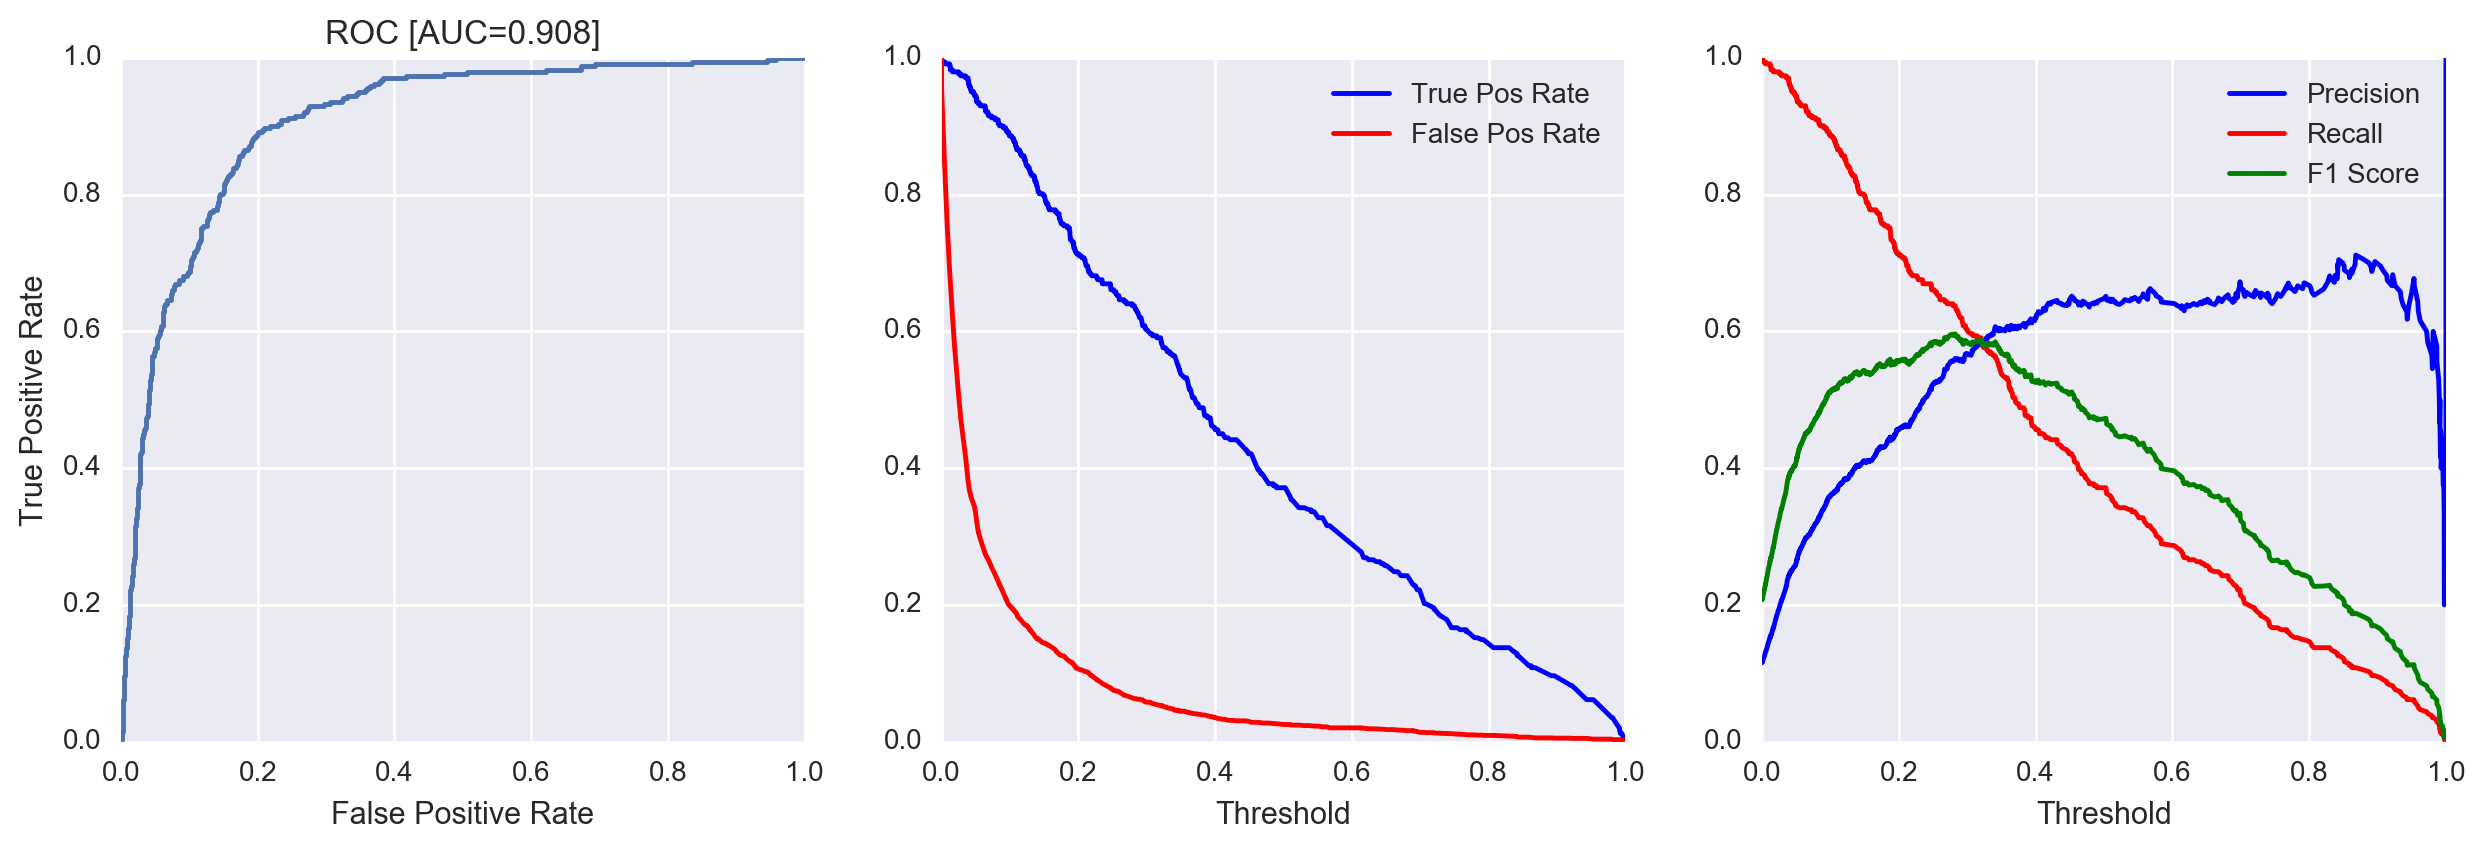

In [61]:
col = 'domestic_violence_victim'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)

In [62]:
new_idx = odds_df.index.tolist()
new_idx = ['project_' + x.split('_')[-1] if x.split('_')[0] == 'project' else x for x in new_idx]
new_idx = ['living_' + x.split('_')[-1] if x.split('_')[0] == 'living' else x for x in new_idx]
new_idx = ['status_' + x.split('_')[-1] if x.split('_')[0] == 'housing' else x for x in new_idx]
new_idx = ['noncash_' + x.split('_')[-1] if x.split('_')[0] == 'noncash' else x for x in new_idx]
new_idx = ['health_' + x.split('_')[-1] if x.split('_')[0] == 'health' else x for x in new_idx]
new_idx = ['disable_' + x.split('_')[-1] if x.split('_')[0] == 'disability' else x for x in new_idx]

odds_df.index = new_idx
odds_df = odds_df.dropna(how='all')

coef_df.index = new_idx
coef_df = coef_df.dropna(how='all')

In [63]:
stat_df.head()

n  n_perm_housing  prop_perm_housing
gender_female     4848.0           363.0           0.074876
gender_male       6503.0           785.0           0.120714
veteran_status_1  2191.0           669.0           0.305340
veteran_status_0  9171.0           479.0           0.052230
ethnicity_latino  5207.0           419.0           0.080469

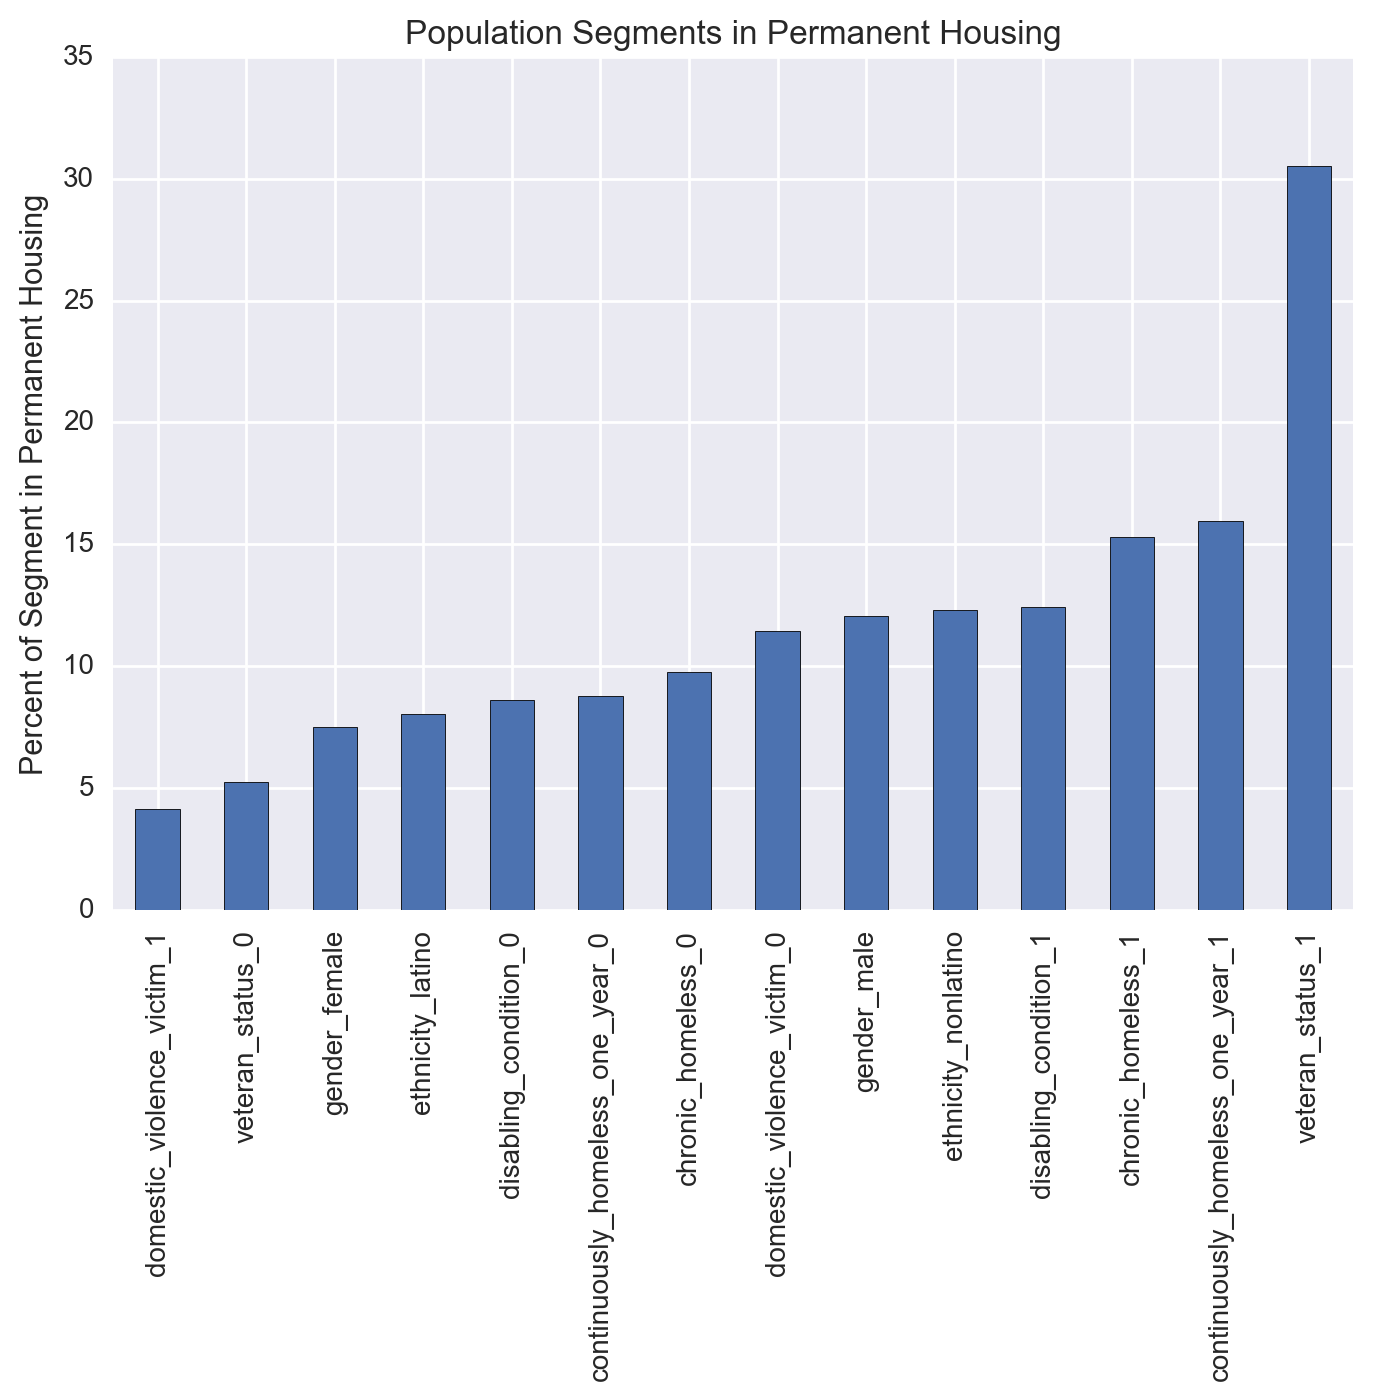

In [64]:
fig, ax = plt.subplots()
stat_df['prop_perm_housing'].sort_values().mul(100).plot(ax=ax, kind='bar');
ax.set_ylabel('Percent of Segment in Permanent Housing');
ax.set_title('Population Segments in Permanent Housing');

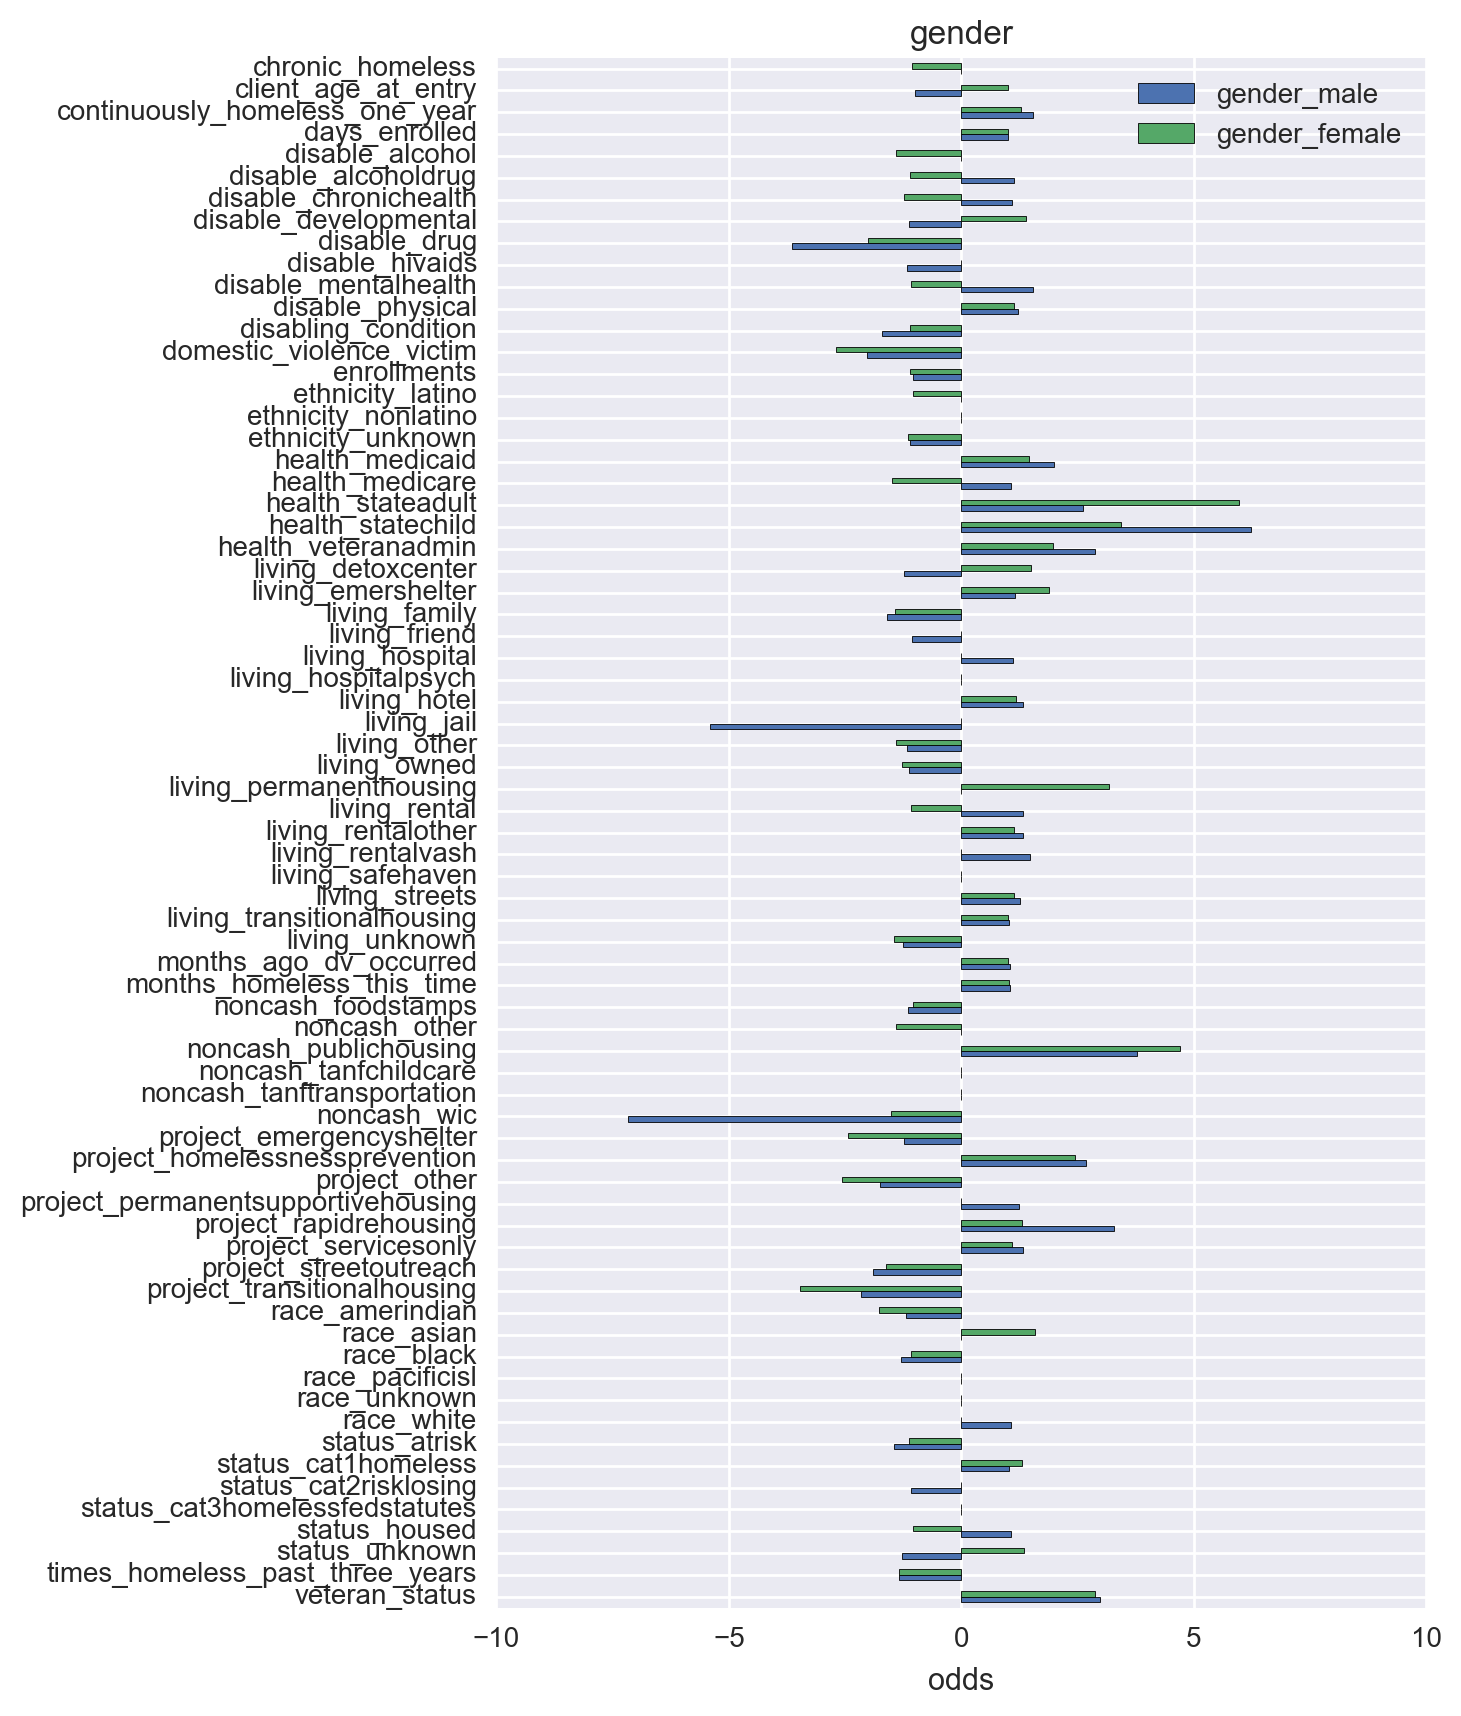

In [65]:
these_cols = ['gender_male', 'gender_female',]
# these_cols = ['ethnicity_latino', 'ethnicity_nonlatino']
# these_cols = ['veteran_status_1', 'veteran_status_0']
# these_cols = ['chronic_homeless_1', 'chronic_homeless_0']
# these_cols = ['continuously_homeless_one_year_1', 'continuously_homeless_one_year_0']
# these_cols = ['disabling_condition_1', 'disabling_condition_0']
# these_cols = ['domestic_violence_victim_1', 'domestic_violence_victim_0']

group_name = os.path.commonprefix(these_cols)[:-1]

xlim = (-10, 10)

# ncols = 1
# if ncols > len(these_cols):
#     ncols = len(these_cols)
# nrows = int(np.ceil(len(these_cols) / ncols))

fig, ax = plt.subplots(figsize=(6, 10))

odds_df[these_cols].dropna(how='all').sort_index(ascending=False).plot(ax=ax, kind='barh');
ax.set_title(group_name);
ax.set_xlabel('odds');
ax.set_xlim(xlim);

### TODO: color code categories

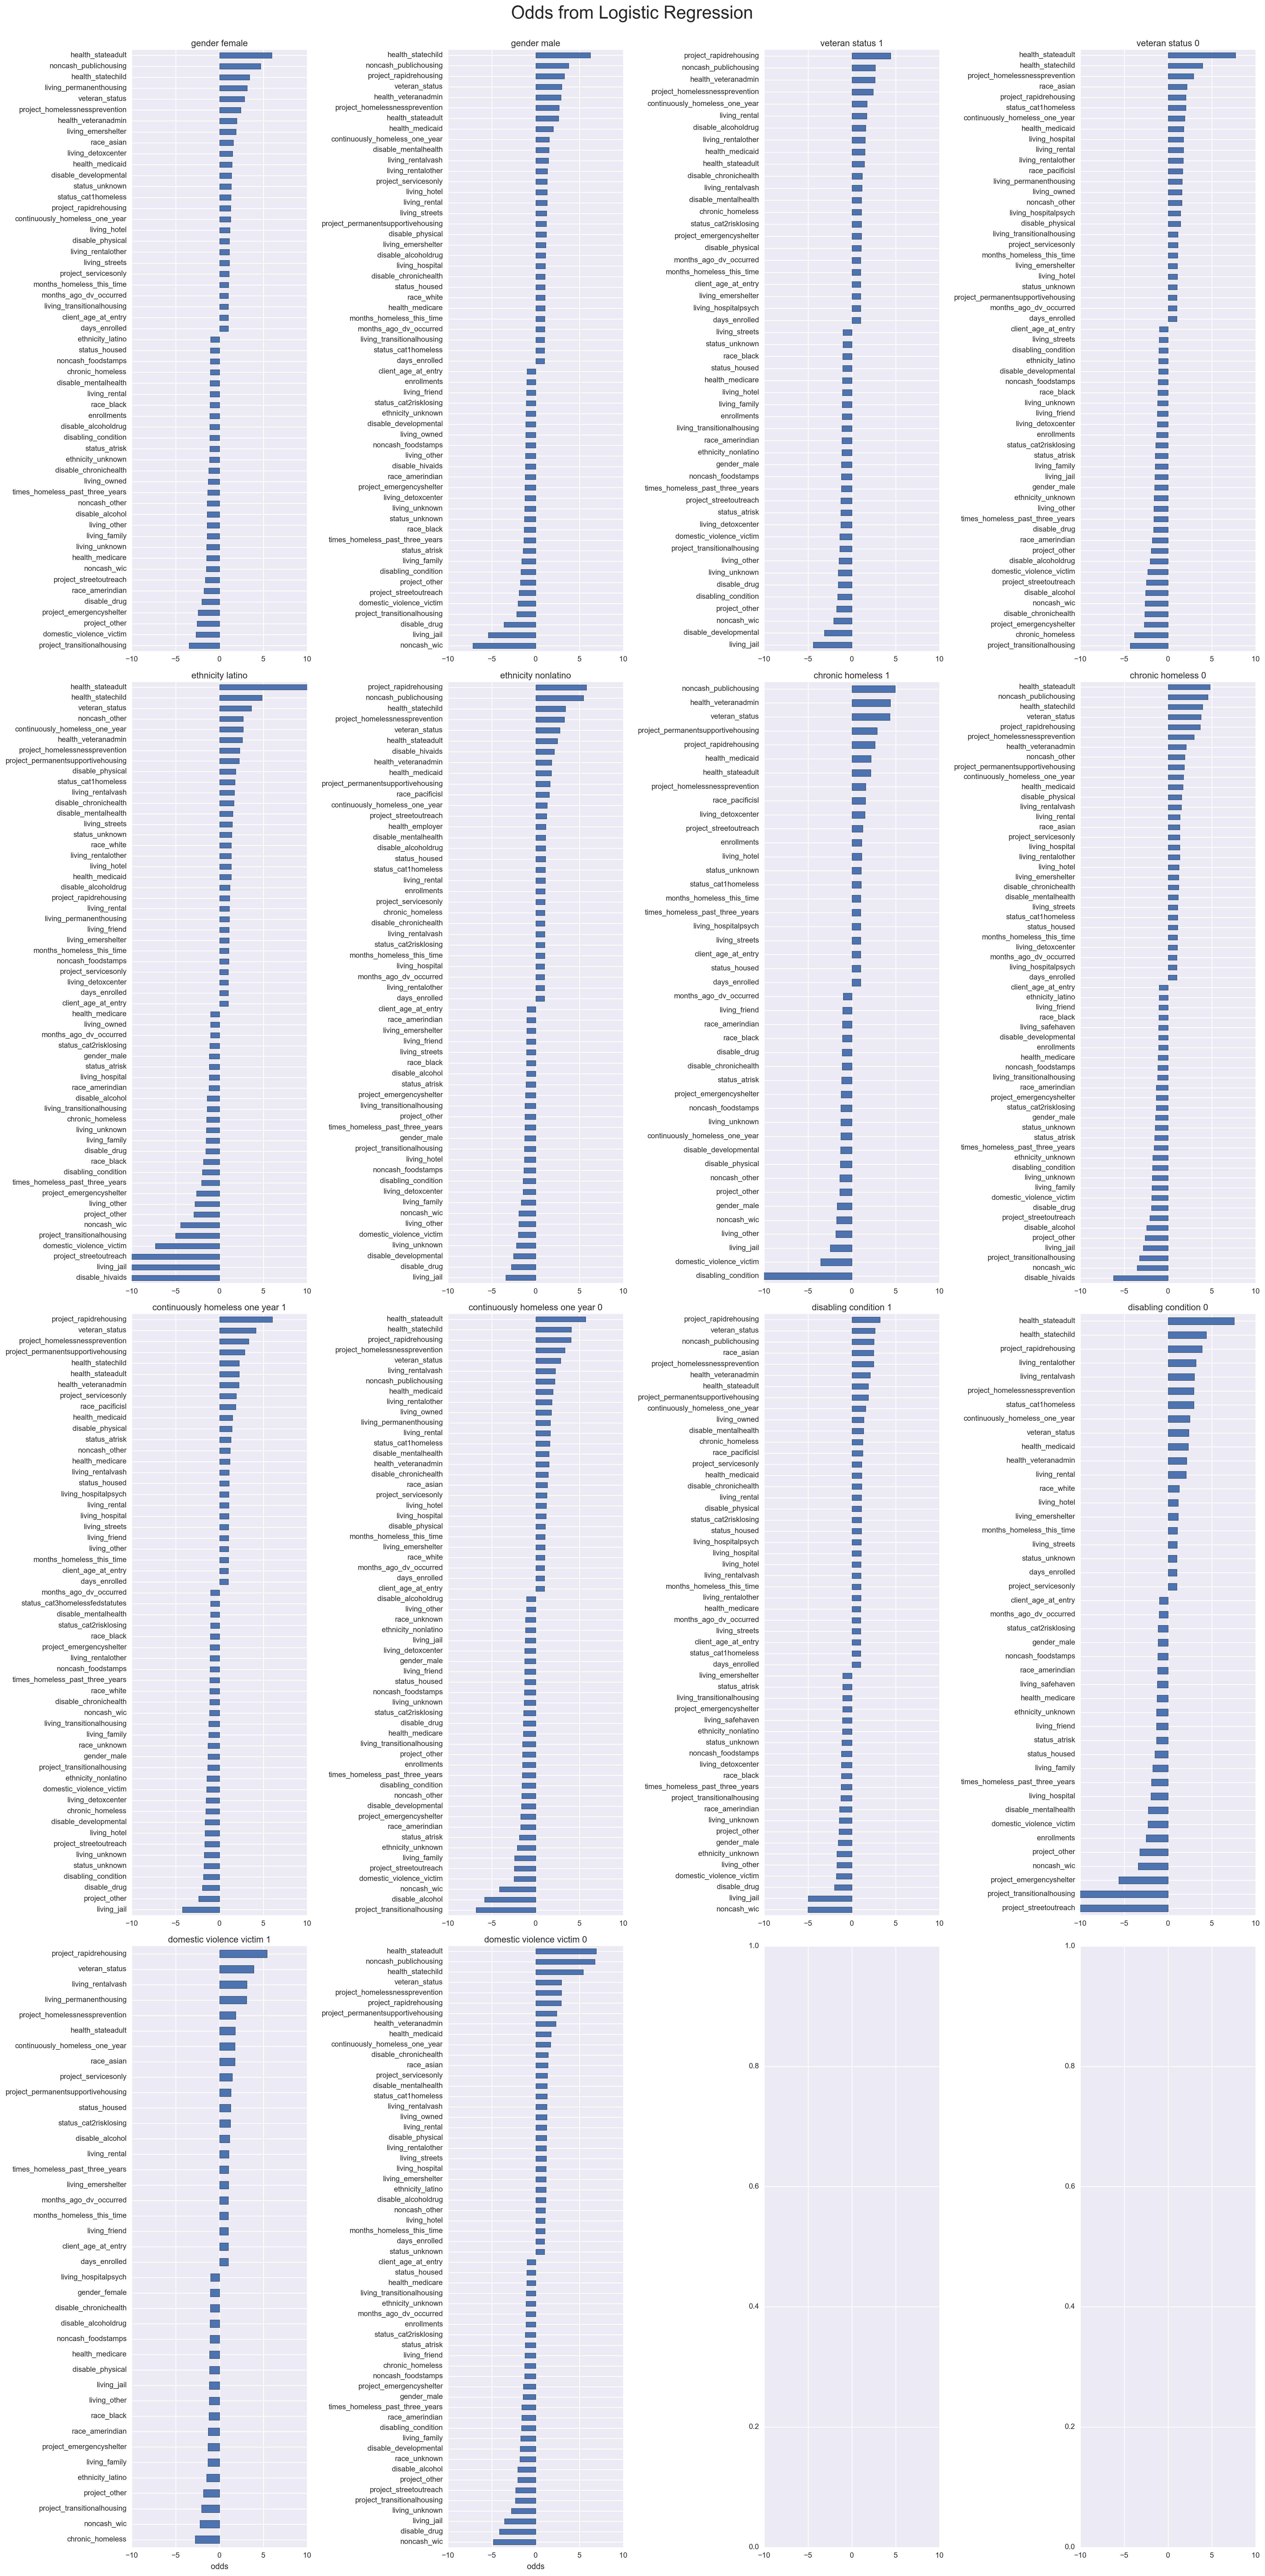

In [66]:
these_cols = odds_df.columns

ncols = 4

xlim = (-10, 10)

if ncols > len(these_cols):
    ncols = len(these_cols)
nrows = int(np.ceil(len(these_cols) / ncols))

fig, (axes) = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, sharey=False,
                           figsize=(6*ncols, 12*nrows))

for col, ax in zip(these_cols, axes.ravel()):
    odds_df.loc[(odds_df[col] != 0) & ((odds_df[col] < -1.0) | (odds_df[col] > 1.0)), col].dropna(how='all').sort_values(ascending=True).plot(ax=ax, kind='barh');
    #odds_df[col].dropna(how='all').sort_values(ascending=True).plot(ax=ax, kind='barh');
    ax.set_title(col.replace('_', ' '));
    ax.set_xlabel('odds');
    ax.set_xlim(xlim);

# turn on the x and y tick labels even when sharing axes
[([tk.set_visible(True) for tk in ax.get_xticklabels()],
  [tk.set_visible(True) for tk in ax.get_yticklabels()]) for ax in axes.flatten()];

fig.tight_layout();

fig.suptitle('Odds from Logistic Regression', fontsize=24, y=1.01);
# fig.subplots_adjust(top=0.85);

In [67]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=2, shuffle=True)

# outcome = 'in_permanent_housing'
# outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing',
#                   'head_of_household',
#                   ]
# y = df_model_num[outcome].values
# X = df_model_num.drop(outcome_related, axis=1)

# # X = X.apply(lambda x: x.fillna(x.median()),axis=0) 

# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
#     y_train, y_test = y[train_index], y[test_index]

# print(X_train.shape)
# print(X_test.shape)

In [68]:
# results, myAuc, precision, recall, f1, myLR = cu.classify(X_train, X_test,
#                                                           y_train, y_test,
#                                                           'lr',
#                                                           print_n_features=20);

In [69]:
# results, myAuc, precision, recall, f1, myRF = cu.classify(X_train, X_test,
#                                                           y_train, y_test,
#                                                           'rf',
#                                                           n_estimators=10,
#                                                           min_samples_leaf=20,
#                                                           print_n_features=30);

In [70]:
# from sklearn import tree

# for i, tr in enumerate(myRF.estimators_):
#     tree.export_graphviz(tr, feature_names=X_train.columns, filled=True, rounded=True,
#                          class_names=['no', 'yes'],
#                          out_file='/Users/mattmollison/Desktop/trees/tree_{}.dot'.format(i))

In [71]:
# results = pd.DataFrame(myRF.feature_importances_, index=X_train.columns, columns=['importance'])
# results['std'] = np.std([tree.feature_importances_ for tree in myRF.estimators_], axis=0)

# results = results.sort_values(['importance'], ascending=False)

# results = results.iloc[:20, :]

# fig, ax = plt.subplots()
# results['importance'].iloc[::-1].plot(kind='barh', xerr=results['std'].iloc[::-1], ax=ax);

# ax.set(title='Random Forest feature importance',
#       );